In [1]:
from pyght.src.AnniesLasso.thecannon.vectorizer.polynomial import PolynomialVectorizer
from pyght.src.AnniesLasso.thecannon.model import CannonModel
from astropy.io import fits
import numpy as np

In [13]:
filepath = '/data/mustard/vmehta/sfh_100_10_20251023_130110/sfh_100_10_20251023_130110'
labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

data = fits.getdata(f"{filepath}_weights.fits")
data = np.log10(data)

flux = np.load(f"{filepath}_snr100_spectra.npy", allow_pickle=True)
ivar = np.load(f"{filepath}_snr100_invvar.npy", allow_pickle=True)
wav = np.load(f"{filepath}_wavelength.npy", allow_pickle=True)

vectorizer = PolynomialVectorizer(labels, 2)

In [14]:
model = CannonModel(data, flux, ivar, vectorizer=vectorizer, dispersion=wav)

model.train(nonoise_training=False)
model.write('model_withs2.pkl')

2025-10-24 09:10:06,690 [INFO] Training 10-label CannonModel with 100 stars and 2222 pixels/star
stty: 'standard input'2025-10-24 09:10:06,695 [DEBUG] Couldn't get screen size. Progressbar may look odd.
: Inappropriate ioctl for device
2025-10-24 09:10:06,701 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   0% (1/2222)                          

2025-10-24 09:10:06,778 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   0% (2/2222)                          

2025-10-24 09:10:06,839 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   0% (3/2222)                          

2025-10-24 09:10:06,904 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   0% (6/2222)                          

2025-10-24 09:10:06,976 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   0% (7/2222)                          

2025-10-24 09:10:07,041 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   0% (10/2222)                          

2025-10-24 09:10:07,097 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   1% (14/2222)                          

2025-10-24 09:10:07,170 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   1% (20/2222)                          

2025-10-24 09:10:07,251 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   1% (21/2222)                          

2025-10-24 09:10:07,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   1% (25/2222)                          

2025-10-24 09:10:07,394 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   1% (28/2222)                          

2025-10-24 09:10:07,473 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   1% (30/2222)                          

2025-10-24 09:10:07,539 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   1% (31/2222)                          

2025-10-24 09:10:07,597 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   1% (32/2222)                          

2025-10-24 09:10:07,661 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   2% (36/2222)                          

2025-10-24 09:10:07,738 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   2% (37/2222)                          

2025-10-24 09:10:07,802 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   2% (43/2222)                          

2025-10-24 09:10:07,883 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==                                                                                                  ]   2% (48/2222)                          

2025-10-24 09:10:07,956 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==                                                                                                  ]   2% (52/2222)                          

2025-10-24 09:10:08,028 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==                                                                                                  ]   3% (63/2222)                          

2025-10-24 09:10:08,124 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==                                                                                                  ]   3% (64/2222)                          

2025-10-24 09:10:08,179 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   3% (69/2222)                          

2025-10-24 09:10:08,257 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   3% (72/2222)                          

2025-10-24 09:10:08,328 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   3% (74/2222)                          

2025-10-24 09:10:08,382 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   4% (83/2222)                          

2025-10-24 09:10:08,478 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   4% (85/2222)                          

2025-10-24 09:10:08,536 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   4% (86/2222)                          

2025-10-24 09:10:08,599 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   4% (89/2222)                          

2025-10-24 09:10:08,670 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   4% (90/2222)                          

2025-10-24 09:10:08,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   4% (91/2222)                          

2025-10-24 09:10:08,781 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   4% (92/2222)                          

2025-10-24 09:10:08,838 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   4% (95/2222)                          

2025-10-24 09:10:08,903 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   5% (104/2222)                          

2025-10-24 09:10:08,997 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   5% (107/2222)                          

2025-10-24 09:10:09,068 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   5% (109/2222)                          

2025-10-24 09:10:09,132 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   5% (114/2222)                          

2025-10-24 09:10:09,203 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   5% (115/2222)                          

2025-10-24 09:10:09,258 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   5% (116/2222)                          

2025-10-24 09:10:09,306 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   5% (120/2222)                          

2025-10-24 09:10:09,364 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   5% (121/2222)                          

2025-10-24 09:10:09,415 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   6% (123/2222)                          

2025-10-24 09:10:09,470 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   6% (128/2222)                          

2025-10-24 09:10:09,536 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   6% (130/2222)                          

2025-10-24 09:10:09,591 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   6% (132/2222)                          

2025-10-24 09:10:09,648 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   6% (133/2222)                          

2025-10-24 09:10:09,701 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   6% (135/2222)                          

2025-10-24 09:10:09,758 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   6% (138/2222)                          

2025-10-24 09:10:09,814 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   6% (140/2222)                          

2025-10-24 09:10:09,868 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   6% (144/2222)                          

2025-10-24 09:10:09,926 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   7% (146/2222)                          

2025-10-24 09:10:09,978 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   7% (149/2222)                          

2025-10-24 09:10:10,033 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   7% (153/2222)                          

2025-10-24 09:10:10,091 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (154/2222)                          

2025-10-24 09:10:10,141 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (159/2222)                          

2025-10-24 09:10:10,209 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (161/2222)                          

2025-10-24 09:10:10,269 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (163/2222)                          

2025-10-24 09:10:10,323 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (164/2222)                          

2025-10-24 09:10:10,381 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (165/2222)                          

2025-10-24 09:10:10,433 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (166/2222)                          

2025-10-24 09:10:10,481 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   8% (168/2222)                          

2025-10-24 09:10:10,535 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   8% (174/2222)                          

2025-10-24 09:10:10,605 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   8% (179/2222)                          

2025-10-24 09:10:10,670 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   8% (182/2222)                          

2025-10-24 09:10:10,731 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   8% (183/2222)                          

2025-10-24 09:10:10,785 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   8% (184/2222)                          

2025-10-24 09:10:10,837 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   8% (187/2222)                          

2025-10-24 09:10:10,900 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   9% (189/2222)                          

2025-10-24 09:10:10,957 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   9% (194/2222)                          

2025-10-24 09:10:11,053 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   9% (195/2222)                          

2025-10-24 09:10:11,105 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]   9% (199/2222)                          

2025-10-24 09:10:11,172 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]   9% (201/2222)                          

2025-10-24 09:10:11,246 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]   9% (208/2222)                          

2025-10-24 09:10:11,320 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]   9% (210/2222)                          

2025-10-24 09:10:11,367 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]  10% (216/2222)                          

2025-10-24 09:10:11,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]  10% (218/2222)                          

2025-10-24 09:10:11,487 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (220/2222)                          

2025-10-24 09:10:11,539 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (221/2222)                          

2025-10-24 09:10:11,588 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (223/2222)                          

2025-10-24 09:10:11,643 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (225/2222)                          

2025-10-24 09:10:11,697 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (230/2222)                          

2025-10-24 09:10:11,766 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (232/2222)                          

2025-10-24 09:10:11,818 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  11% (235/2222)                          

2025-10-24 09:10:11,875 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  11% (240/2222)                          

2025-10-24 09:10:11,942 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  11% (241/2222)                          

2025-10-24 09:10:11,987 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (242/2222)                          

2025-10-24 09:10:12,035 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (243/2222)                          

2025-10-24 09:10:12,087 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (249/2222)                          

2025-10-24 09:10:12,160 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (251/2222)                          

2025-10-24 09:10:12,220 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (253/2222)                          

2025-10-24 09:10:12,278 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (254/2222)                          

2025-10-24 09:10:12,333 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (255/2222)                          

2025-10-24 09:10:12,381 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  12% (257/2222)                          

2025-10-24 09:10:12,437 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  12% (259/2222)                          

2025-10-24 09:10:12,491 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  12% (260/2222)                          

2025-10-24 09:10:12,538 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  12% (263/2222)                          

2025-10-24 09:10:12,597 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  12% (270/2222)                          

2025-10-24 09:10:12,668 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  12% (272/2222)                          

2025-10-24 09:10:12,722 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  12% (274/2222)                          

2025-10-24 09:10:12,772 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  13% (278/2222)                          

2025-10-24 09:10:12,835 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  13% (279/2222)                          

2025-10-24 09:10:12,890 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  13% (280/2222)                          

2025-10-24 09:10:12,939 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  13% (282/2222)                          

2025-10-24 09:10:12,992 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  13% (284/2222)                          

2025-10-24 09:10:13,045 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  13% (285/2222)                          

2025-10-24 09:10:13,093 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (290/2222)                          

2025-10-24 09:10:13,159 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (295/2222)                          

2025-10-24 09:10:13,258 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (296/2222)                          

2025-10-24 09:10:13,308 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (297/2222)                          

2025-10-24 09:10:13,356 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (299/2222)                          

2025-10-24 09:10:13,407 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  14% (301/2222)                          

2025-10-24 09:10:13,459 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  14% (305/2222)                          

2025-10-24 09:10:13,520 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  14% (307/2222)                          

2025-10-24 09:10:13,577 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  14% (310/2222)                          

2025-10-24 09:10:13,630 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  14% (312/2222)                          

2025-10-24 09:10:13,677 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  14% (313/2222)                          

2025-10-24 09:10:13,724 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  14% (318/2222)                          

2025-10-24 09:10:13,785 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  15% (323/2222)                          

2025-10-24 09:10:13,847 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  15% (328/2222)                          

2025-10-24 09:10:13,912 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  15% (334/2222)                          

2025-10-24 09:10:13,978 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  15% (337/2222)                          

2025-10-24 09:10:14,034 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  15% (339/2222)                          

2025-10-24 09:10:14,093 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  15% (341/2222)                          

2025-10-24 09:10:14,145 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  16% (349/2222)                          

2025-10-24 09:10:14,219 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (354/2222)                          

2025-10-24 09:10:14,285 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (356/2222)                          

2025-10-24 09:10:14,336 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (357/2222)                          

2025-10-24 09:10:14,386 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (361/2222)                          

2025-10-24 09:10:14,447 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (362/2222)                          

2025-10-24 09:10:14,500 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (365/2222)                          

2025-10-24 09:10:14,561 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (366/2222)                          

2025-10-24 09:10:14,612 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  17% (370/2222)                          

2025-10-24 09:10:14,675 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  17% (371/2222)                          

2025-10-24 09:10:14,722 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  17% (373/2222)                          

2025-10-24 09:10:14,777 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  17% (375/2222)                          

2025-10-24 09:10:14,831 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  17% (377/2222)                          

2025-10-24 09:10:14,882 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  17% (378/2222)                          

2025-10-24 09:10:14,932 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  17% (379/2222)                          

2025-10-24 09:10:14,978 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  18% (394/2222)                          

2025-10-24 09:10:15,080 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  18% (395/2222)                          

2025-10-24 09:10:15,128 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (398/2222)                          

2025-10-24 09:10:15,191 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (400/2222)                          

2025-10-24 09:10:15,245 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (401/2222)                          

2025-10-24 09:10:15,296 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (403/2222)                          

2025-10-24 09:10:15,351 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (404/2222)                          

2025-10-24 09:10:15,400 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (405/2222)                          

2025-10-24 09:10:15,450 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (406/2222)                          

2025-10-24 09:10:15,499 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (407/2222)                          

2025-10-24 09:10:15,553 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (408/2222)                          

2025-10-24 09:10:15,603 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (409/2222)                          

2025-10-24 09:10:15,652 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (411/2222)                          

2025-10-24 09:10:15,712 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  19% (414/2222)                          

2025-10-24 09:10:15,770 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  19% (415/2222)                          

2025-10-24 09:10:15,819 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  19% (416/2222)                          

2025-10-24 09:10:15,868 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  19% (418/2222)                          

2025-10-24 09:10:15,921 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  19% (419/2222)                          

2025-10-24 09:10:15,970 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  19% (425/2222)                          

2025-10-24 09:10:16,035 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  19% (426/2222)                          

2025-10-24 09:10:16,084 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  19% (427/2222)                          

2025-10-24 09:10:16,132 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  20% (436/2222)                          

2025-10-24 09:10:16,216 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  20% (437/2222)                          

2025-10-24 09:10:16,262 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  20% (438/2222)                          

2025-10-24 09:10:16,307 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  20% (439/2222)                          

2025-10-24 09:10:16,352 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (441/2222)                          

2025-10-24 09:10:16,404 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (449/2222)                          

2025-10-24 09:10:16,478 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (450/2222)                          

2025-10-24 09:10:16,524 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (451/2222)                          

2025-10-24 09:10:16,573 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (452/2222)                          

2025-10-24 09:10:16,620 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  21% (457/2222)                          

2025-10-24 09:10:16,684 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  21% (458/2222)                          

2025-10-24 09:10:16,735 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  21% (459/2222)                          

2025-10-24 09:10:16,783 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  21% (467/2222)                          

2025-10-24 09:10:16,857 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  21% (472/2222)                          

2025-10-24 09:10:16,920 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  21% (475/2222)                          

2025-10-24 09:10:16,979 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  22% (479/2222)                          

2025-10-24 09:10:17,041 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  22% (481/2222)                          

2025-10-24 09:10:17,090 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  22% (482/2222)                          

2025-10-24 09:10:17,139 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  22% (484/2222)                          

2025-10-24 09:10:17,193 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  22% (485/2222)                          

2025-10-24 09:10:17,247 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  22% (487/2222)                          

2025-10-24 09:10:17,300 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  22% (491/2222)                          

2025-10-24 09:10:17,361 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  22% (492/2222)                          

2025-10-24 09:10:17,408 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  22% (497/2222)                          

2025-10-24 09:10:17,470 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  23% (502/2222)                          

2025-10-24 09:10:17,532 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (508/2222)                          

2025-10-24 09:10:17,601 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (511/2222)                          

2025-10-24 09:10:17,662 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (513/2222)                          

2025-10-24 09:10:17,717 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (515/2222)                          

2025-10-24 09:10:17,768 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (517/2222)                          

2025-10-24 09:10:17,818 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (518/2222)                          

2025-10-24 09:10:17,868 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (522/2222)                          

2025-10-24 09:10:17,929 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  24% (523/2222)                          

2025-10-24 09:10:17,981 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  24% (524/2222)                          

2025-10-24 09:10:18,030 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  24% (526/2222)                          

2025-10-24 09:10:18,081 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (528/2222)                          

2025-10-24 09:10:18,138 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (529/2222)                          

2025-10-24 09:10:18,188 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (530/2222)                          

2025-10-24 09:10:18,239 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (531/2222)                          

2025-10-24 09:10:18,288 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (534/2222)                          

2025-10-24 09:10:18,346 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (535/2222)                          

2025-10-24 09:10:18,396 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (538/2222)                          

2025-10-24 09:10:18,451 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  25% (545/2222)                          

2025-10-24 09:10:18,528 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  25% (546/2222)                          

2025-10-24 09:10:18,579 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  25% (548/2222)                          

2025-10-24 09:10:18,634 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (551/2222)                          

2025-10-24 09:10:18,689 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (556/2222)                          

2025-10-24 09:10:18,753 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (557/2222)                          

2025-10-24 09:10:18,803 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (558/2222)                          

2025-10-24 09:10:18,855 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (562/2222)                          

2025-10-24 09:10:18,916 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (563/2222)                          

2025-10-24 09:10:18,965 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (564/2222)                          

2025-10-24 09:10:19,017 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (565/2222)                          

2025-10-24 09:10:19,070 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  26% (568/2222)                          

2025-10-24 09:10:19,130 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  26% (569/2222)                          

2025-10-24 09:10:19,179 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  26% (571/2222)                          

2025-10-24 09:10:19,231 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (573/2222)                          

2025-10-24 09:10:19,284 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (575/2222)                          

2025-10-24 09:10:19,336 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (576/2222)                          

2025-10-24 09:10:19,387 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (577/2222)                          

2025-10-24 09:10:19,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (578/2222)                          

2025-10-24 09:10:19,481 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (579/2222)                          

2025-10-24 09:10:19,528 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  27% (589/2222)                          

2025-10-24 09:10:19,614 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (595/2222)                          

2025-10-24 09:10:19,680 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (596/2222)                          

2025-10-24 09:10:19,729 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (598/2222)                          

2025-10-24 09:10:19,784 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (603/2222)                          

2025-10-24 09:10:19,851 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (605/2222)                          

2025-10-24 09:10:19,906 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (606/2222)                          

2025-10-24 09:10:19,960 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (609/2222)                          

2025-10-24 09:10:20,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (611/2222)                          

2025-10-24 09:10:20,078 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  28% (612/2222)                          

2025-10-24 09:10:20,128 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  28% (613/2222)                          

2025-10-24 09:10:20,178 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (616/2222)                          

2025-10-24 09:10:20,237 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (618/2222)                          

2025-10-24 09:10:20,291 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (621/2222)                          

2025-10-24 09:10:20,348 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (622/2222)                          

2025-10-24 09:10:20,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (623/2222)                          

2025-10-24 09:10:20,450 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (629/2222)                          

2025-10-24 09:10:20,518 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (632/2222)                          

2025-10-24 09:10:20,577 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  29% (634/2222)                          

2025-10-24 09:10:20,636 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  29% (635/2222)                          

2025-10-24 09:10:20,687 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  29% (636/2222)                          

2025-10-24 09:10:20,737 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  29% (637/2222)                          

2025-10-24 09:10:20,786 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (641/2222)                          

2025-10-24 09:10:20,847 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (644/2222)                          

2025-10-24 09:10:20,910 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (645/2222)                          

2025-10-24 09:10:20,955 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (650/2222)                          

2025-10-24 09:10:21,018 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (651/2222)                          

2025-10-24 09:10:21,067 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (652/2222)                          

2025-10-24 09:10:21,117 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  30% (656/2222)                          

2025-10-24 09:10:21,178 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (660/2222)                          

2025-10-24 09:10:21,242 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (666/2222)                          

2025-10-24 09:10:21,311 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (669/2222)                          

2025-10-24 09:10:21,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (671/2222)                          

2025-10-24 09:10:21,566 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (672/2222)                          

2025-10-24 09:10:21,684 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (674/2222)                          

2025-10-24 09:10:21,811 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  31% (679/2222)                          

2025-10-24 09:10:21,958 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (683/2222)                          

2025-10-24 09:10:22,092 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (685/2222)                          

2025-10-24 09:10:22,151 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (688/2222)                          

2025-10-24 09:10:22,209 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (689/2222)                          

2025-10-24 09:10:22,259 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (690/2222)                          

2025-10-24 09:10:22,308 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (692/2222)                          

2025-10-24 09:10:22,362 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (693/2222)                          

2025-10-24 09:10:22,414 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (695/2222)                          

2025-10-24 09:10:22,469 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (696/2222)                          

2025-10-24 09:10:22,522 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (699/2222)                          

2025-10-24 09:10:22,583 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  32% (700/2222)                          

2025-10-24 09:10:22,633 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (706/2222)                          

2025-10-24 09:10:22,702 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (712/2222)                          

2025-10-24 09:10:22,772 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (713/2222)                          

2025-10-24 09:10:22,822 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (715/2222)                          

2025-10-24 09:10:22,877 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (717/2222)                          

2025-10-24 09:10:22,930 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (721/2222)                          

2025-10-24 09:10:22,990 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  33% (723/2222)                          

2025-10-24 09:10:23,041 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (729/2222)                          

2025-10-24 09:10:23,109 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (730/2222)                          

2025-10-24 09:10:23,156 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (731/2222)                          

2025-10-24 09:10:23,205 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (734/2222)                          

2025-10-24 09:10:23,261 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (735/2222)                          

2025-10-24 09:10:23,311 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (740/2222)                          

2025-10-24 09:10:23,376 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  34% (746/2222)                          

2025-10-24 09:10:23,444 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (751/2222)                          

2025-10-24 09:10:23,509 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (754/2222)                          

2025-10-24 09:10:23,566 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (756/2222)                          

2025-10-24 09:10:23,622 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (757/2222)                          

2025-10-24 09:10:23,674 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (758/2222)                          

2025-10-24 09:10:23,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (759/2222)                          

2025-10-24 09:10:23,774 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (761/2222)                          

2025-10-24 09:10:23,828 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  35% (767/2222)                          

2025-10-24 09:10:23,897 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  35% (779/2222)                          

2025-10-24 09:10:23,995 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  35% (784/2222)                          

2025-10-24 09:10:24,064 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  35% (786/2222)                          

2025-10-24 09:10:24,118 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  35% (787/2222)                          

2025-10-24 09:10:24,170 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  36% (789/2222)                          

2025-10-24 09:10:24,226 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  36% (790/2222)                          

2025-10-24 09:10:24,276 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (793/2222)                          

2025-10-24 09:10:24,334 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (800/2222)                          

2025-10-24 09:10:24,408 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (802/2222)                          

2025-10-24 09:10:24,464 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (804/2222)                          

2025-10-24 09:10:24,516 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (805/2222)                          

2025-10-24 09:10:24,571 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  37% (813/2222)                          

2025-10-24 09:10:24,654 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (814/2222)                          

2025-10-24 09:10:24,706 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (823/2222)                          

2025-10-24 09:10:24,783 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (826/2222)                          

2025-10-24 09:10:24,840 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (827/2222)                          

2025-10-24 09:10:24,888 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (830/2222)                          

2025-10-24 09:10:24,945 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (831/2222)                          

2025-10-24 09:10:24,992 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (832/2222)                          

2025-10-24 09:10:25,039 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (833/2222)                          

2025-10-24 09:10:25,083 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (837/2222)                          

2025-10-24 09:10:25,144 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (842/2222)                          

2025-10-24 09:10:25,214 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (845/2222)                          

2025-10-24 09:10:25,276 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (846/2222)                          

2025-10-24 09:10:25,325 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (849/2222)                          

2025-10-24 09:10:25,384 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (851/2222)                          

2025-10-24 09:10:25,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (853/2222)                          

2025-10-24 09:10:25,490 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  39% (856/2222)                          

2025-10-24 09:10:25,544 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (858/2222)                          

2025-10-24 09:10:25,597 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (859/2222)                          

2025-10-24 09:10:25,651 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (860/2222)                          

2025-10-24 09:10:25,701 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (863/2222)                          

2025-10-24 09:10:25,759 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (865/2222)                          

2025-10-24 09:10:25,815 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (874/2222)                          

2025-10-24 09:10:25,896 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (875/2222)                          

2025-10-24 09:10:25,950 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (876/2222)                          

2025-10-24 09:10:25,999 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  40% (878/2222)                          

2025-10-24 09:10:26,053 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  40% (879/2222)                          

2025-10-24 09:10:26,104 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (883/2222)                          

2025-10-24 09:10:26,165 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (884/2222)                          

2025-10-24 09:10:26,217 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (886/2222)                          

2025-10-24 09:10:26,274 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (889/2222)                          

2025-10-24 09:10:26,330 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (893/2222)                          

2025-10-24 09:10:26,393 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (894/2222)                          

2025-10-24 09:10:26,441 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (895/2222)                          

2025-10-24 09:10:26,491 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (899/2222)                          

2025-10-24 09:10:26,556 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================                                                           ]  41% (909/2222)                          

2025-10-24 09:10:26,642 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================                                                           ]  41% (910/2222)                          

2025-10-24 09:10:26,692 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================                                                           ]  41% (916/2222)                          

2025-10-24 09:10:26,761 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  42% (935/2222)                          

2025-10-24 09:10:26,885 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  42% (940/2222)                          

2025-10-24 09:10:26,948 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  42% (942/2222)                          

2025-10-24 09:10:26,999 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  43% (945/2222)                          

2025-10-24 09:10:27,059 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (947/2222)                          

2025-10-24 09:10:27,113 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (954/2222)                          

2025-10-24 09:10:27,189 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (955/2222)                          

2025-10-24 09:10:27,238 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (964/2222)                          

2025-10-24 09:10:27,319 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (965/2222)                          

2025-10-24 09:10:27,366 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  44% (967/2222)                          

2025-10-24 09:10:27,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (968/2222)                          

2025-10-24 09:10:27,466 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (970/2222)                          

2025-10-24 09:10:27,519 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (974/2222)                          

2025-10-24 09:10:27,581 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (976/2222)                          

2025-10-24 09:10:27,639 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (977/2222)                          

2025-10-24 09:10:27,691 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (979/2222)                          

2025-10-24 09:10:27,746 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (980/2222)                          

2025-10-24 09:10:27,800 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (983/2222)                          

2025-10-24 09:10:27,860 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (985/2222)                          

2025-10-24 09:10:27,913 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (990/2222)                          

2025-10-24 09:10:27,980 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (994/2222)                          

2025-10-24 09:10:28,044 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (995/2222)                          

2025-10-24 09:10:28,100 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (996/2222)                          

2025-10-24 09:10:28,151 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (1004/2222)                          

2025-10-24 09:10:28,231 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (1006/2222)                          

2025-10-24 09:10:28,286 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (1011/2222)                          

2025-10-24 09:10:28,355 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1012/2222)                          

2025-10-24 09:10:28,408 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1016/2222)                          

2025-10-24 09:10:28,472 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1020/2222)                          

2025-10-24 09:10:28,538 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1022/2222)                          

2025-10-24 09:10:28,594 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1024/2222)                          

2025-10-24 09:10:28,650 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1029/2222)                          

2025-10-24 09:10:28,720 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1031/2222)                          

2025-10-24 09:10:28,777 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1032/2222)                          

2025-10-24 09:10:28,831 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1037/2222)                          

2025-10-24 09:10:28,903 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1038/2222)                          

2025-10-24 09:10:28,954 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1040/2222)                          

2025-10-24 09:10:29,011 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1042/2222)                          

2025-10-24 09:10:29,069 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1044/2222)                          

2025-10-24 09:10:29,129 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1051/2222)                          

2025-10-24 09:10:29,202 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1052/2222)                          

2025-10-24 09:10:29,253 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1059/2222)                          

2025-10-24 09:10:29,331 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1063/2222)                          

2025-10-24 09:10:29,392 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1065/2222)                          

2025-10-24 09:10:29,448 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1066/2222)                          

2025-10-24 09:10:29,498 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1067/2222)                          

2025-10-24 09:10:29,550 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1069/2222)                          

2025-10-24 09:10:29,617 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1073/2222)                          

2025-10-24 09:10:29,679 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1075/2222)                          

2025-10-24 09:10:29,730 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1076/2222)                          

2025-10-24 09:10:29,781 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1078/2222)                          

2025-10-24 09:10:29,834 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1079/2222)                          

2025-10-24 09:10:29,882 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1082/2222)                          

2025-10-24 09:10:29,939 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1086/2222)                          

2025-10-24 09:10:30,001 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1092/2222)                          

2025-10-24 09:10:30,067 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1093/2222)                          

2025-10-24 09:10:30,115 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1094/2222)                          

2025-10-24 09:10:30,165 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1100/2222)                          

2025-10-24 09:10:30,238 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1103/2222)                          

2025-10-24 09:10:30,295 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1104/2222)                          

2025-10-24 09:10:30,346 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1105/2222)                          

2025-10-24 09:10:30,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1109/2222)                          

2025-10-24 09:10:30,460 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1111/2222)                          

2025-10-24 09:10:30,512 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1113/2222)                          

2025-10-24 09:10:30,569 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1115/2222)                          

2025-10-24 09:10:30,624 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1116/2222)                          

2025-10-24 09:10:30,675 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1119/2222)                          

2025-10-24 09:10:30,735 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1124/2222)                          

2025-10-24 09:10:30,802 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1125/2222)                          

2025-10-24 09:10:30,857 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1129/2222)                          

2025-10-24 09:10:30,920 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1130/2222)                          

2025-10-24 09:10:30,969 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1131/2222)                          

2025-10-24 09:10:31,019 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1134/2222)                          

2025-10-24 09:10:31,077 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1135/2222)                          

2025-10-24 09:10:31,128 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1141/2222)                          

2025-10-24 09:10:31,196 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1142/2222)                          

2025-10-24 09:10:31,249 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  51% (1144/2222)                          

2025-10-24 09:10:31,302 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1146/2222)                          

2025-10-24 09:10:31,355 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1149/2222)                          

2025-10-24 09:10:31,410 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1150/2222)                          

2025-10-24 09:10:31,459 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1154/2222)                          

2025-10-24 09:10:31,516 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1155/2222)                          

2025-10-24 09:10:31,568 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1162/2222)                          

2025-10-24 09:10:31,640 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1163/2222)                          

2025-10-24 09:10:31,688 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1164/2222)                          

2025-10-24 09:10:31,739 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1167/2222)                          

2025-10-24 09:10:31,800 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1170/2222)                          

2025-10-24 09:10:31,854 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1173/2222)                          

2025-10-24 09:10:31,909 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1174/2222)                          

2025-10-24 09:10:31,957 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1175/2222)                          

2025-10-24 09:10:32,009 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1179/2222)                          

2025-10-24 09:10:32,069 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1181/2222)                          

2025-10-24 09:10:32,119 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1186/2222)                          

2025-10-24 09:10:32,183 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1189/2222)                          

2025-10-24 09:10:32,247 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1190/2222)                          

2025-10-24 09:10:32,296 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1194/2222)                          

2025-10-24 09:10:32,356 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1197/2222)                          

2025-10-24 09:10:32,410 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1199/2222)                          

2025-10-24 09:10:32,468 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1200/2222)                          

2025-10-24 09:10:32,519 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1206/2222)                          

2025-10-24 09:10:32,594 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================                                             ]  55% (1216/2222)                          

2025-10-24 09:10:32,682 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================                                             ]  55% (1229/2222)                          

2025-10-24 09:10:32,780 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  55% (1232/2222)                          

2025-10-24 09:10:32,843 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  55% (1233/2222)                          

2025-10-24 09:10:32,894 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1236/2222)                          

2025-10-24 09:10:32,956 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1239/2222)                          

2025-10-24 09:10:33,016 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1240/2222)                          

2025-10-24 09:10:33,065 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1243/2222)                          

2025-10-24 09:10:33,122 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1253/2222)                          

2025-10-24 09:10:33,210 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  56% (1254/2222)                          

2025-10-24 09:10:33,263 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  57% (1260/2222)                          

2025-10-24 09:10:33,333 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  57% (1262/2222)                          

2025-10-24 09:10:33,386 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  57% (1264/2222)                          

2025-10-24 09:10:33,443 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  57% (1274/2222)                          

2025-10-24 09:10:33,531 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  57% (1276/2222)                          

2025-10-24 09:10:33,587 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  58% (1279/2222)                          

2025-10-24 09:10:33,647 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  58% (1282/2222)                          

2025-10-24 09:10:33,709 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  58% (1292/2222)                          

2025-10-24 09:10:33,793 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  58% (1294/2222)                          

2025-10-24 09:10:33,849 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  58% (1295/2222)                          

2025-10-24 09:10:33,896 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  58% (1297/2222)                          

2025-10-24 09:10:33,950 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1303/2222)                          

2025-10-24 09:10:34,020 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1304/2222)                          

2025-10-24 09:10:34,069 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1305/2222)                          

2025-10-24 09:10:34,119 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1307/2222)                          

2025-10-24 09:10:34,171 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1313/2222)                          

2025-10-24 09:10:34,243 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1314/2222)                          

2025-10-24 09:10:34,293 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  59% (1321/2222)                          

2025-10-24 09:10:34,370 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  60% (1324/2222)                          

2025-10-24 09:10:34,427 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  60% (1328/2222)                          

2025-10-24 09:10:34,488 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  60% (1334/2222)                          

2025-10-24 09:10:34,559 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  60% (1335/2222)                          

2025-10-24 09:10:34,607 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  60% (1340/2222)                          

2025-10-24 09:10:34,673 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1345/2222)                          

2025-10-24 09:10:34,737 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1346/2222)                          

2025-10-24 09:10:34,785 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1347/2222)                          

2025-10-24 09:10:34,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1353/2222)                          

2025-10-24 09:10:34,908 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1356/2222)                          

2025-10-24 09:10:34,966 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1357/2222)                          

2025-10-24 09:10:35,014 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1359/2222)                          

2025-10-24 09:10:35,068 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  61% (1365/2222)                          

2025-10-24 09:10:35,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  62% (1368/2222)                          

2025-10-24 09:10:35,195 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  62% (1373/2222)                          

2025-10-24 09:10:35,262 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  62% (1375/2222)                          

2025-10-24 09:10:35,320 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  62% (1376/2222)                          

2025-10-24 09:10:35,374 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  62% (1382/2222)                          

2025-10-24 09:10:35,440 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  62% (1386/2222)                          

2025-10-24 09:10:35,501 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1389/2222)                          

2025-10-24 09:10:35,559 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1393/2222)                          

2025-10-24 09:10:35,622 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1396/2222)                          

2025-10-24 09:10:35,680 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1397/2222)                          

2025-10-24 09:10:35,728 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1401/2222)                          

2025-10-24 09:10:35,792 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1405/2222)                          

2025-10-24 09:10:35,856 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1412/2222)                          

2025-10-24 09:10:35,930 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1413/2222)                          

2025-10-24 09:10:35,978 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1416/2222)                          

2025-10-24 09:10:36,037 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1420/2222)                          

2025-10-24 09:10:36,102 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1424/2222)                          

2025-10-24 09:10:36,168 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1425/2222)                          

2025-10-24 09:10:36,220 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1426/2222)                          

2025-10-24 09:10:36,271 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================                                   ]  64% (1431/2222)                          

2025-10-24 09:10:36,336 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================                                   ]  64% (1432/2222)                          

2025-10-24 09:10:36,386 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================                                   ]  65% (1434/2222)                          

2025-10-24 09:10:36,440 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================                                   ]  65% (1436/2222)                          

2025-10-24 09:10:36,494 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================                                   ]  65% (1440/2222)                          

2025-10-24 09:10:36,559 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================                                   ]  65% (1448/2222)                          

2025-10-24 09:10:36,635 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  65% (1453/2222)                          

2025-10-24 09:10:36,700 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  65% (1454/2222)                          

2025-10-24 09:10:36,749 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1457/2222)                          

2025-10-24 09:10:36,804 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1461/2222)                          

2025-10-24 09:10:36,862 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1467/2222)                          

2025-10-24 09:10:36,927 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1469/2222)                          

2025-10-24 09:10:36,978 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1471/2222)                          

2025-10-24 09:10:37,030 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1472/2222)                          

2025-10-24 09:10:37,078 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================                                 ]  66% (1475/2222)                          

2025-10-24 09:10:37,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================                                 ]  67% (1484/2222)                          

2025-10-24 09:10:37,219 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================                                 ]  67% (1485/2222)                          

2025-10-24 09:10:37,267 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================                                 ]  67% (1486/2222)                          

2025-10-24 09:10:37,318 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  67% (1496/2222)                          

2025-10-24 09:10:37,408 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  68% (1504/2222)                          

2025-10-24 09:10:37,487 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  68% (1508/2222)                          

2025-10-24 09:10:37,544 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  68% (1509/2222)                          

2025-10-24 09:10:37,593 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  68% (1515/2222)                          

2025-10-24 09:10:37,659 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  68% (1518/2222)                          

2025-10-24 09:10:37,713 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  68% (1521/2222)                          

2025-10-24 09:10:37,772 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  69% (1528/2222)                          

2025-10-24 09:10:37,845 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  69% (1535/2222)                          

2025-10-24 09:10:37,916 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  69% (1538/2222)                          

2025-10-24 09:10:37,971 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================                              ]  69% (1544/2222)                          

2025-10-24 09:10:38,039 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================                              ]  70% (1554/2222)                          

2025-10-24 09:10:38,123 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================                              ]  70% (1558/2222)                          

2025-10-24 09:10:38,183 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================                              ]  70% (1559/2222)                          

2025-10-24 09:10:38,236 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1570/2222)                          

2025-10-24 09:10:38,325 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1572/2222)                          

2025-10-24 09:10:38,375 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1573/2222)                          

2025-10-24 09:10:38,425 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1576/2222)                          

2025-10-24 09:10:38,481 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1577/2222)                          

2025-10-24 09:10:38,533 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1582/2222)                          

2025-10-24 09:10:38,596 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1583/2222)                          

2025-10-24 09:10:38,645 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================                            ]  72% (1591/2222)                          

2025-10-24 09:10:38,723 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================                            ]  72% (1593/2222)                          

2025-10-24 09:10:38,780 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================                            ]  72% (1596/2222)                          

2025-10-24 09:10:38,843 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================                            ]  72% (1598/2222)                          

2025-10-24 09:10:38,896 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================                            ]  72% (1603/2222)                          

2025-10-24 09:10:38,962 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  72% (1607/2222)                          

2025-10-24 09:10:39,024 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  72% (1608/2222)                          

2025-10-24 09:10:39,078 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  73% (1615/2222)                          

2025-10-24 09:10:39,149 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  73% (1618/2222)                          

2025-10-24 09:10:39,208 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  73% (1619/2222)                          

2025-10-24 09:10:39,263 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  73% (1620/2222)                          

2025-10-24 09:10:39,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  73% (1622/2222)                          

2025-10-24 09:10:39,375 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================                          ]  73% (1628/2222)                          

2025-10-24 09:10:39,445 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================                          ]  74% (1635/2222)                          

2025-10-24 09:10:39,547 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================                          ]  74% (1644/2222)                          

2025-10-24 09:10:39,633 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  74% (1654/2222)                          

2025-10-24 09:10:39,721 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  75% (1660/2222)                          

2025-10-24 09:10:39,790 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  75% (1663/2222)                          

2025-10-24 09:10:39,846 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  75% (1671/2222)                          

2025-10-24 09:10:39,924 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================                        ]  75% (1674/2222)                          

2025-10-24 09:10:39,981 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================                        ]  76% (1682/2222)                          

2025-10-24 09:10:40,060 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================                        ]  76% (1683/2222)                          

2025-10-24 09:10:40,114 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================                        ]  76% (1685/2222)                          

2025-10-24 09:10:40,172 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================                        ]  76% (1688/2222)                          

2025-10-24 09:10:40,233 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================                       ]  76% (1694/2222)                          

2025-10-24 09:10:40,305 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================                       ]  77% (1700/2222)                          

2025-10-24 09:10:40,375 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================                       ]  77% (1703/2222)                          

2025-10-24 09:10:40,436 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================                       ]  77% (1705/2222)                          

2025-10-24 09:10:40,485 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  77% (1719/2222)                          

2025-10-24 09:10:40,584 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  77% (1721/2222)                          

2025-10-24 09:10:40,639 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  77% (1722/2222)                          

2025-10-24 09:10:40,688 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  78% (1724/2222)                          

2025-10-24 09:10:40,743 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  78% (1728/2222)                          

2025-10-24 09:10:40,806 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  78% (1730/2222)                          

2025-10-24 09:10:40,858 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  78% (1731/2222)                          

2025-10-24 09:10:40,909 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================                     ]  79% (1746/2222)                          

2025-10-24 09:10:41,013 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================                     ]  79% (1748/2222)                          

2025-10-24 09:10:41,064 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================                     ]  79% (1751/2222)                          

2025-10-24 09:10:41,118 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================                     ]  79% (1757/2222)                          

2025-10-24 09:10:41,187 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================                    ]  79% (1763/2222)                          

2025-10-24 09:10:41,259 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================                    ]  79% (1764/2222)                          

2025-10-24 09:10:41,310 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================                    ]  80% (1777/2222)                          

2025-10-24 09:10:41,403 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================                   ]  80% (1785/2222)                          

2025-10-24 09:10:41,478 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================                   ]  81% (1794/2222)                          

2025-10-24 09:10:41,558 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================                   ]  81% (1795/2222)                          

2025-10-24 09:10:41,606 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================                   ]  81% (1796/2222)                          

2025-10-24 09:10:41,657 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================                   ]  81% (1803/2222)                          

2025-10-24 09:10:41,729 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================                  ]  81% (1805/2222)                          

2025-10-24 09:10:41,783 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================                  ]  82% (1813/2222)                          

2025-10-24 09:10:41,860 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================                  ]  82% (1816/2222)                          

2025-10-24 09:10:41,916 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================                  ]  82% (1823/2222)                          

2025-10-24 09:10:41,990 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================                  ]  82% (1825/2222)                          

2025-10-24 09:10:42,043 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================================                 ]  82% (1829/2222)                          

2025-10-24 09:10:42,104 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================================                 ]  82% (1831/2222)                          

2025-10-24 09:10:42,160 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================================                 ]  83% (1836/2222)                          

2025-10-24 09:10:42,231 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================================                 ]  83% (1839/2222)                          

2025-10-24 09:10:42,291 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================================                 ]  83% (1843/2222)                          

2025-10-24 09:10:42,354 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  83% (1850/2222)                          

2025-10-24 09:10:42,431 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  83% (1852/2222)                          

2025-10-24 09:10:42,487 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1856/2222)                          

2025-10-24 09:10:42,548 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1858/2222)                          

2025-10-24 09:10:42,605 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1862/2222)                          

2025-10-24 09:10:42,670 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1863/2222)                          

2025-10-24 09:10:42,721 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1865/2222)                          

2025-10-24 09:10:42,777 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1869/2222)                          

2025-10-24 09:10:42,841 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  84% (1872/2222)                          

2025-10-24 09:10:42,899 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  84% (1873/2222)                          

2025-10-24 09:10:42,947 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  85% (1878/2222)                          

2025-10-24 09:10:43,015 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  85% (1883/2222)                          

2025-10-24 09:10:43,079 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  85% (1888/2222)                          

2025-10-24 09:10:43,145 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================================              ]  85% (1895/2222)                          

2025-10-24 09:10:43,221 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================================              ]  86% (1901/2222)                          

2025-10-24 09:10:43,292 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================================              ]  86% (1904/2222)                          

2025-10-24 09:10:43,353 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================================              ]  86% (1908/2222)                          

2025-10-24 09:10:43,419 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================================              ]  86% (1912/2222)                          

2025-10-24 09:10:43,484 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  86% (1916/2222)                          

2025-10-24 09:10:43,548 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  86% (1918/2222)                          

2025-10-24 09:10:43,611 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  86% (1919/2222)                          

2025-10-24 09:10:43,666 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  86% (1920/2222)                          

2025-10-24 09:10:43,724 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  87% (1924/2222)                          

2025-10-24 09:10:43,791 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  87% (1926/2222)                          

2025-10-24 09:10:43,852 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  87% (1928/2222)                          

2025-10-24 09:10:43,919 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  87% (1929/2222)                          

2025-10-24 09:10:43,975 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  87% (1932/2222)                          

2025-10-24 09:10:44,043 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================================            ]  88% (1945/2222)                          

2025-10-24 09:10:44,153 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================================            ]  88% (1947/2222)                          

2025-10-24 09:10:44,214 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================================            ]  88% (1948/2222)                          

2025-10-24 09:10:44,273 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================================            ]  88% (1956/2222)                          

2025-10-24 09:10:44,359 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================================            ]  88% (1957/2222)                          

2025-10-24 09:10:44,410 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  88% (1958/2222)                          

2025-10-24 09:10:44,461 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  88% (1959/2222)                          

2025-10-24 09:10:44,512 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  88% (1964/2222)                          

2025-10-24 09:10:44,580 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  89% (1969/2222)                          

2025-10-24 09:10:44,648 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  89% (1973/2222)                          

2025-10-24 09:10:44,709 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  89% (1977/2222)                          

2025-10-24 09:10:44,771 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================================          ]  89% (1981/2222)                          

2025-10-24 09:10:44,834 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================================          ]  89% (1983/2222)                          

2025-10-24 09:10:44,891 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================================          ]  89% (1987/2222)                          

2025-10-24 09:10:44,962 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================================         ]  90% (2002/2222)                          

2025-10-24 09:10:45,065 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================================         ]  90% (2003/2222)                          

2025-10-24 09:10:45,115 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================================         ]  90% (2007/2222)                          

2025-10-24 09:10:45,180 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================================         ]  90% (2010/2222)                          

2025-10-24 09:10:45,240 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================================         ]  91% (2017/2222)                          

2025-10-24 09:10:45,313 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  91% (2027/2222)                          

2025-10-24 09:10:45,400 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  91% (2028/2222)                          

2025-10-24 09:10:45,454 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  91% (2032/2222)                          

2025-10-24 09:10:45,519 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  91% (2033/2222)                          

2025-10-24 09:10:45,570 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  92% (2036/2222)                          

2025-10-24 09:10:45,627 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  92% (2037/2222)                          

2025-10-24 09:10:45,682 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  92% (2038/2222)                          

2025-10-24 09:10:45,733 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  92% (2039/2222)                          

2025-10-24 09:10:45,786 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  92% (2042/2222)                          

2025-10-24 09:10:45,855 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================================       ]  92% (2049/2222)                          

2025-10-24 09:10:45,928 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================================       ]  92% (2054/2222)                          

2025-10-24 09:10:46,001 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================================       ]  93% (2056/2222)                          

2025-10-24 09:10:46,058 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================================       ]  93% (2059/2222)                          

2025-10-24 09:10:46,117 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  93% (2068/2222)                          

2025-10-24 09:10:46,200 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  93% (2069/2222)                          

2025-10-24 09:10:46,255 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  93% (2072/2222)                          

2025-10-24 09:10:46,315 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  93% (2073/2222)                          

2025-10-24 09:10:46,366 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  93% (2074/2222)                          

2025-10-24 09:10:46,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  93% (2076/2222)                          

2025-10-24 09:10:46,489 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  94% (2079/2222)                          

2025-10-24 09:10:46,559 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  94% (2090/2222)                          

2025-10-24 09:10:46,666 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  95% (2102/2222)                          

2025-10-24 09:10:46,766 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  95% (2105/2222)                          

2025-10-24 09:10:46,824 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  95% (2106/2222)                          

2025-10-24 09:10:46,884 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  95% (2108/2222)                          

2025-10-24 09:10:46,951 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  95% (2115/2222)                          

2025-10-24 09:10:47,037 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  95% (2120/2222)                          

2025-10-24 09:10:47,109 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  95% (2121/2222)                          

2025-10-24 09:10:47,169 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  96% (2124/2222)                          

2025-10-24 09:10:47,231 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  96% (2125/2222)                          

2025-10-24 09:10:47,292 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  96% (2128/2222)                          

2025-10-24 09:10:47,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  96% (2132/2222)                          

2025-10-24 09:10:47,430 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  96% (2134/2222)                          

2025-10-24 09:10:47,496 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  96% (2137/2222)                          

2025-10-24 09:10:47,563 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  96% (2138/2222)                          

2025-10-24 09:10:47,622 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  96% (2139/2222)                          

2025-10-24 09:10:47,686 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  96% (2141/2222)                          

2025-10-24 09:10:47,744 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  97% (2150/2222)                          

2025-10-24 09:10:47,832 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================================  ]  98% (2169/2222)                          

2025-10-24 09:10:47,964 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================================  ]  98% (2175/2222)                          

2025-10-24 09:10:48,043 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  98% (2179/2222)                          

2025-10-24 09:10:48,114 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  98% (2180/2222)                          

2025-10-24 09:10:48,170 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  98% (2182/2222)                          

2025-10-24 09:10:48,233 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  98% (2184/2222)                          

2025-10-24 09:10:48,296 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  98% (2186/2222)                          

2025-10-24 09:10:48,363 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  99% (2194/2222)                          

2025-10-24 09:10:48,462 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  99% (2196/2222)                          

2025-10-24 09:10:48,527 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  99% (2197/2222)                          

2025-10-24 09:10:48,593 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================================]  99% (2204/2222)                          

2025-10-24 09:10:48,679 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================================] 100% (42s)                               
Saved model to model_withs2.pkl


In [15]:
import pickle

model_withs2 = pickle.load(open('model_withs2.pkl', 'rb'))
model_withs2['s2']

array([0., 0., 0., ..., 0., 0., 0.], shape=(2222,))

In [16]:
model.train(nonoise_training=True)
model.write('model_nos2.pkl')

2025-10-24 09:10:48,907 [INFO] Training 10-label CannonModel with 100 stars and 2222 pixels/star
stty: 'standard input'2025-10-24 09:10:48,934 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[                                                                                                    ]   0% (1/2222)                          

: Inappropriate ioctl for device
2025-10-24 09:10:48,941 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   0% (2/2222)                          

2025-10-24 09:10:48,986 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   0% (3/2222)                          

2025-10-24 09:10:49,032 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   0% (6/2222)                          

2025-10-24 09:10:49,080 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   0% (7/2222)                          

2025-10-24 09:10:49,124 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   0% (8/2222)                          

2025-10-24 09:10:49,170 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   1% (14/2222)                          

2025-10-24 09:10:49,225 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[                                                                                                    ]   1% (20/2222)                          

2025-10-24 09:10:49,278 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   1% (22/2222)                          

2025-10-24 09:10:49,326 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   1% (24/2222)                          

2025-10-24 09:10:49,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   1% (27/2222)                          

2025-10-24 09:10:49,422 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   1% (28/2222)                          

2025-10-24 09:10:49,468 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   1% (30/2222)                          

2025-10-24 09:10:49,517 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   1% (32/2222)                          

2025-10-24 09:10:49,562 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=                                                                                                   ]   2% (37/2222)                          

2025-10-24 09:10:49,613 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==                                                                                                  ]   2% (48/2222)                          

2025-10-24 09:10:49,672 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==                                                                                                  ]   2% (50/2222)                          

2025-10-24 09:10:49,721 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==                                                                                                  ]   2% (51/2222)                          

2025-10-24 09:10:49,769 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==                                                                                                  ]   2% (52/2222)                          

2025-10-24 09:10:49,817 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==                                                                                                  ]   3% (63/2222)                          

2025-10-24 09:10:49,877 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==                                                                                                  ]   3% (64/2222)                          

2025-10-24 09:10:49,921 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   3% (66/2222)                          

2025-10-24 09:10:49,971 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   3% (72/2222)                          

2025-10-24 09:10:50,025 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   3% (74/2222)                          

2025-10-24 09:10:50,075 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   3% (77/2222)                          

2025-10-24 09:10:50,129 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   4% (82/2222)                          

2025-10-24 09:10:50,180 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   4% (83/2222)                          

2025-10-24 09:10:50,228 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===                                                                                                 ]   4% (86/2222)                          

2025-10-24 09:10:50,277 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   4% (89/2222)                          

2025-10-24 09:10:50,328 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   4% (90/2222)                          

2025-10-24 09:10:50,376 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   4% (92/2222)                          

2025-10-24 09:10:50,423 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   4% (95/2222)                          

2025-10-24 09:10:50,472 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   4% (96/2222)                          

2025-10-24 09:10:50,520 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   4% (98/2222)                          

2025-10-24 09:10:50,570 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   5% (103/2222)                          

2025-10-24 09:10:50,623 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   5% (104/2222)                          

2025-10-24 09:10:50,667 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====                                                                                                ]   5% (109/2222)                          

2025-10-24 09:10:50,721 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   5% (110/2222)                          

2025-10-24 09:10:50,764 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   5% (115/2222)                          

2025-10-24 09:10:50,814 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   5% (117/2222)                          

2025-10-24 09:10:50,864 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   5% (120/2222)                          

2025-10-24 09:10:50,915 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   5% (121/2222)                          

2025-10-24 09:10:50,959 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   6% (123/2222)                          

2025-10-24 09:10:51,004 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   6% (126/2222)                          

2025-10-24 09:10:51,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   6% (130/2222)                          

2025-10-24 09:10:51,107 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====                                                                                               ]   6% (131/2222)                          

2025-10-24 09:10:51,153 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   6% (132/2222)                          

2025-10-24 09:10:51,202 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   6% (135/2222)                          

2025-10-24 09:10:51,251 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   6% (138/2222)                          

2025-10-24 09:10:51,299 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   7% (146/2222)                          

2025-10-24 09:10:51,353 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   7% (148/2222)                          

2025-10-24 09:10:51,398 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   7% (149/2222)                          

2025-10-24 09:10:51,440 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======                                                                                              ]   7% (153/2222)                          

2025-10-24 09:10:51,487 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (154/2222)                          

2025-10-24 09:10:51,528 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (159/2222)                          

2025-10-24 09:10:51,576 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (161/2222)                          

2025-10-24 09:10:51,621 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (163/2222)                          

2025-10-24 09:10:51,666 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (164/2222)                          

2025-10-24 09:10:51,712 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (165/2222)                          

2025-10-24 09:10:51,757 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   7% (166/2222)                          

2025-10-24 09:10:51,800 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   8% (170/2222)                          

2025-10-24 09:10:51,850 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======                                                                                             ]   8% (174/2222)                          

2025-10-24 09:10:51,903 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   8% (178/2222)                          

2025-10-24 09:10:51,953 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   8% (181/2222)                          

2025-10-24 09:10:52,002 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   8% (182/2222)                          

2025-10-24 09:10:52,048 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   8% (183/2222)                          

2025-10-24 09:10:52,090 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   8% (185/2222)                          

2025-10-24 09:10:52,135 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   8% (187/2222)                          

2025-10-24 09:10:52,183 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   9% (192/2222)                          

2025-10-24 09:10:52,239 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   9% (194/2222)                          

2025-10-24 09:10:52,284 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========                                                                                            ]   9% (195/2222)                          

2025-10-24 09:10:52,330 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]   9% (199/2222)                          

2025-10-24 09:10:52,379 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]   9% (204/2222)                          

2025-10-24 09:10:52,428 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]   9% (207/2222)                          

2025-10-24 09:10:52,473 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]   9% (208/2222)                          

2025-10-24 09:10:52,519 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]   9% (209/2222)                          

2025-10-24 09:10:52,562 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]   9% (210/2222)                          

2025-10-24 09:10:52,607 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]  10% (216/2222)                          

2025-10-24 09:10:52,657 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========                                                                                           ]  10% (218/2222)                          

2025-10-24 09:10:52,703 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (220/2222)                          

2025-10-24 09:10:52,747 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (223/2222)                          

2025-10-24 09:10:52,794 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (225/2222)                          

2025-10-24 09:10:52,838 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (227/2222)                          

2025-10-24 09:10:52,882 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (230/2222)                          

2025-10-24 09:10:52,930 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  10% (232/2222)                          

2025-10-24 09:10:52,975 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========                                                                                          ]  11% (235/2222)                          

2025-10-24 09:10:53,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (242/2222)                          

2025-10-24 09:10:53,076 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (243/2222)                          

2025-10-24 09:10:53,120 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (244/2222)                          

2025-10-24 09:10:53,166 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (245/2222)                          

2025-10-24 09:10:53,210 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (249/2222)                          

2025-10-24 09:10:53,261 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (251/2222)                          

2025-10-24 09:10:53,309 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (253/2222)                          

2025-10-24 09:10:53,355 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  11% (254/2222)                          

2025-10-24 09:10:53,402 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  12% (256/2222)                          

2025-10-24 09:10:53,455 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  12% (259/2222)                          

2025-10-24 09:10:53,509 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  12% (260/2222)                          

2025-10-24 09:10:53,553 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  12% (262/2222)                          

2025-10-24 09:10:53,601 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========                                                                                         ]  12% (263/2222)                          

2025-10-24 09:10:53,645 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  12% (265/2222)                          

2025-10-24 09:10:53,694 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  12% (266/2222)                          

2025-10-24 09:10:53,743 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  12% (271/2222)                          

2025-10-24 09:10:53,795 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  12% (272/2222)                          

2025-10-24 09:10:53,842 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  12% (274/2222)                          

2025-10-24 09:10:53,889 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  12% (276/2222)                          

2025-10-24 09:10:53,939 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  13% (279/2222)                          

2025-10-24 09:10:53,988 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  13% (280/2222)                          

2025-10-24 09:10:54,033 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  13% (282/2222)                          

2025-10-24 09:10:54,084 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  13% (284/2222)                          

2025-10-24 09:10:54,135 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============                                                                                        ]  13% (285/2222)                          

2025-10-24 09:10:54,182 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (286/2222)                          

2025-10-24 09:10:54,230 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (289/2222)                          

2025-10-24 09:10:54,278 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (290/2222)                          

2025-10-24 09:10:54,323 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (295/2222)                          

2025-10-24 09:10:54,375 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (296/2222)                          

2025-10-24 09:10:54,419 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (297/2222)                          

2025-10-24 09:10:54,464 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  13% (299/2222)                          

2025-10-24 09:10:54,510 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  14% (305/2222)                          

2025-10-24 09:10:54,563 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============                                                                                       ]  14% (307/2222)                          

2025-10-24 09:10:54,610 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  14% (310/2222)                          

2025-10-24 09:10:54,659 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  14% (312/2222)                          

2025-10-24 09:10:54,706 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  14% (313/2222)                          

2025-10-24 09:10:54,749 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  14% (318/2222)                          

2025-10-24 09:10:54,799 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  14% (322/2222)                          

2025-10-24 09:10:54,850 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  15% (323/2222)                          

2025-10-24 09:10:54,897 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============                                                                                      ]  15% (326/2222)                          

2025-10-24 09:10:54,945 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  15% (334/2222)                          

2025-10-24 09:10:55,005 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  15% (336/2222)                          

2025-10-24 09:10:55,053 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  15% (337/2222)                          

2025-10-24 09:10:55,105 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  15% (339/2222)                          

2025-10-24 09:10:55,154 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  15% (341/2222)                          

2025-10-24 09:10:55,204 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  15% (342/2222)                          

2025-10-24 09:10:55,251 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  16% (345/2222)                          

2025-10-24 09:10:55,309 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  16% (346/2222)                          

2025-10-24 09:10:55,359 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============                                                                                     ]  16% (349/2222)                          

2025-10-24 09:10:55,410 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (354/2222)                          

2025-10-24 09:10:55,465 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (355/2222)                          

2025-10-24 09:10:55,513 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (356/2222)                          

2025-10-24 09:10:55,559 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (357/2222)                          

2025-10-24 09:10:55,606 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (358/2222)                          

2025-10-24 09:10:55,654 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (361/2222)                          

2025-10-24 09:10:55,706 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (362/2222)                          

2025-10-24 09:10:55,753 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (365/2222)                          

2025-10-24 09:10:55,805 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  16% (366/2222)                          

2025-10-24 09:10:55,853 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  17% (370/2222)                          

2025-10-24 09:10:55,905 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  17% (371/2222)                          

2025-10-24 09:10:55,953 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  17% (372/2222)                          

2025-10-24 09:10:56,000 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================                                                                                    ]  17% (373/2222)                          

2025-10-24 09:10:56,048 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  17% (375/2222)                          

2025-10-24 09:10:56,096 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  17% (376/2222)                          

2025-10-24 09:10:56,143 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  17% (377/2222)                          

2025-10-24 09:10:56,190 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  17% (378/2222)                          

2025-10-24 09:10:56,238 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  17% (379/2222)                          

2025-10-24 09:10:56,286 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  17% (384/2222)                          

2025-10-24 09:10:56,340 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  17% (386/2222)                          

2025-10-24 09:10:56,390 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  18% (390/2222)                          

2025-10-24 09:10:56,443 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  18% (394/2222)                          

2025-10-24 09:10:56,497 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================                                                                                   ]  18% (395/2222)                          

2025-10-24 09:10:56,546 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (396/2222)                          

2025-10-24 09:10:56,592 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (397/2222)                          

2025-10-24 09:10:56,639 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (398/2222)                          

2025-10-24 09:10:56,687 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (400/2222)                          

2025-10-24 09:10:56,735 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (401/2222)                          

2025-10-24 09:10:56,781 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (402/2222)                          

2025-10-24 09:10:56,830 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (403/2222)                          

2025-10-24 09:10:56,882 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (404/2222)                          

2025-10-24 09:10:56,929 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (406/2222)                          

2025-10-24 09:10:56,977 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (407/2222)                          

2025-10-24 09:10:57,026 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (409/2222)                          

2025-10-24 09:10:57,074 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  18% (411/2222)                          

2025-10-24 09:10:57,122 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  19% (414/2222)                          

2025-10-24 09:10:57,172 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================                                                                                  ]  19% (416/2222)                          

2025-10-24 09:10:57,220 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  19% (418/2222)                          

2025-10-24 09:10:57,268 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  19% (419/2222)                          

2025-10-24 09:10:57,316 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  19% (425/2222)                          

2025-10-24 09:10:57,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  19% (426/2222)                          

2025-10-24 09:10:57,419 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  19% (427/2222)                          

2025-10-24 09:10:57,464 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  20% (436/2222)                          

2025-10-24 09:10:57,525 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  20% (437/2222)                          

2025-10-24 09:10:57,571 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================                                                                                 ]  20% (438/2222)                          

2025-10-24 09:10:57,616 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (440/2222)                          

2025-10-24 09:10:57,662 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (441/2222)                          

2025-10-24 09:10:57,705 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (442/2222)                          

2025-10-24 09:10:57,752 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (446/2222)                          

2025-10-24 09:10:57,802 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (450/2222)                          

2025-10-24 09:10:57,852 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (451/2222)                          

2025-10-24 09:10:57,898 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  20% (452/2222)                          

2025-10-24 09:10:57,943 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  21% (456/2222)                          

2025-10-24 09:10:57,997 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  21% (457/2222)                          

2025-10-24 09:10:58,042 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  21% (458/2222)                          

2025-10-24 09:10:58,089 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================                                                                                ]  21% (459/2222)                          

2025-10-24 09:10:58,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  21% (463/2222)                          

2025-10-24 09:10:58,188 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  21% (466/2222)                          

2025-10-24 09:10:58,241 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  21% (467/2222)                          

2025-10-24 09:10:58,287 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  21% (472/2222)                          

2025-10-24 09:10:58,339 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  21% (473/2222)                          

2025-10-24 09:10:58,387 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  21% (474/2222)                          

2025-10-24 09:10:58,438 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  21% (475/2222)                          

2025-10-24 09:10:58,525 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  22% (479/2222)                          

2025-10-24 09:10:58,579 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  22% (481/2222)                          

2025-10-24 09:10:58,629 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================                                                                               ]  22% (482/2222)                          

2025-10-24 09:10:58,677 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  22% (484/2222)                          

2025-10-24 09:10:58,726 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  22% (485/2222)                          

2025-10-24 09:10:58,772 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  22% (487/2222)                          

2025-10-24 09:10:58,820 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  22% (491/2222)                          

2025-10-24 09:10:58,872 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  22% (497/2222)                          

2025-10-24 09:10:58,928 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  23% (500/2222)                          

2025-10-24 09:10:58,975 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================                                                                              ]  23% (502/2222)                          

2025-10-24 09:10:59,022 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (508/2222)                          

2025-10-24 09:10:59,076 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (511/2222)                          

2025-10-24 09:10:59,126 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (513/2222)                          

2025-10-24 09:10:59,175 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (514/2222)                          

2025-10-24 09:10:59,226 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (515/2222)                          

2025-10-24 09:10:59,274 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (516/2222)                          

2025-10-24 09:10:59,321 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (517/2222)                          

2025-10-24 09:10:59,369 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (518/2222)                          

2025-10-24 09:10:59,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  23% (521/2222)                          

2025-10-24 09:10:59,466 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  24% (523/2222)                          

2025-10-24 09:10:59,513 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================                                                                             ]  24% (524/2222)                          

2025-10-24 09:10:59,560 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (528/2222)                          

2025-10-24 09:10:59,612 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (529/2222)                          

2025-10-24 09:10:59,658 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (530/2222)                          

2025-10-24 09:10:59,703 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (531/2222)                          

2025-10-24 09:10:59,749 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (535/2222)                          

2025-10-24 09:10:59,799 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (538/2222)                          

2025-10-24 09:10:59,846 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  24% (544/2222)                          

2025-10-24 09:10:59,901 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  25% (546/2222)                          

2025-10-24 09:10:59,953 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================                                                                            ]  25% (549/2222)                          

2025-10-24 09:11:00,006 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (551/2222)                          

2025-10-24 09:11:00,057 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (552/2222)                          

2025-10-24 09:11:00,102 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (553/2222)                          

2025-10-24 09:11:00,148 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (555/2222)                          

2025-10-24 09:11:00,200 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (556/2222)                          

2025-10-24 09:11:00,249 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (557/2222)                          

2025-10-24 09:11:00,296 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (558/2222)                          

2025-10-24 09:11:00,342 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (559/2222)                          

2025-10-24 09:11:00,391 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (560/2222)                          

2025-10-24 09:11:00,439 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (561/2222)                          

2025-10-24 09:11:00,486 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (562/2222)                          

2025-10-24 09:11:00,535 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (564/2222)                          

2025-10-24 09:11:00,583 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  25% (566/2222)                          

2025-10-24 09:11:00,634 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  26% (569/2222)                          

2025-10-24 09:11:00,685 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================                                                                           ]  26% (571/2222)                          

2025-10-24 09:11:00,736 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (573/2222)                          

2025-10-24 09:11:00,786 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (575/2222)                          

2025-10-24 09:11:00,835 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (576/2222)                          

2025-10-24 09:11:00,884 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (578/2222)                          

2025-10-24 09:11:00,934 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (579/2222)                          

2025-10-24 09:11:00,980 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (582/2222)                          

2025-10-24 09:11:01,031 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (583/2222)                          

2025-10-24 09:11:01,078 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (584/2222)                          

2025-10-24 09:11:01,123 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================                                                                          ]  26% (585/2222)                          

2025-10-24 09:11:01,171 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (595/2222)                          

2025-10-24 09:11:01,231 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (596/2222)                          

2025-10-24 09:11:01,281 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (598/2222)                          

2025-10-24 09:11:01,331 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (603/2222)                          

2025-10-24 09:11:01,387 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (605/2222)                          

2025-10-24 09:11:01,438 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (606/2222)                          

2025-10-24 09:11:01,484 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  27% (609/2222)                          

2025-10-24 09:11:01,534 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  28% (612/2222)                          

2025-10-24 09:11:01,583 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================                                                                         ]  28% (614/2222)                          

2025-10-24 09:11:01,629 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (616/2222)                          

2025-10-24 09:11:01,678 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (618/2222)                          

2025-10-24 09:11:01,730 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (619/2222)                          

2025-10-24 09:11:01,780 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (620/2222)                          

2025-10-24 09:11:01,831 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (621/2222)                          

2025-10-24 09:11:01,877 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (622/2222)                          

2025-10-24 09:11:01,926 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (627/2222)                          

2025-10-24 09:11:01,984 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (629/2222)                          

2025-10-24 09:11:02,042 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (631/2222)                          

2025-10-24 09:11:02,099 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  28% (632/2222)                          

2025-10-24 09:11:02,152 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  29% (634/2222)                          

2025-10-24 09:11:02,209 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  29% (636/2222)                          

2025-10-24 09:11:02,268 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================                                                                        ]  29% (637/2222)                          

2025-10-24 09:11:02,315 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (638/2222)                          

2025-10-24 09:11:02,366 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (640/2222)                          

2025-10-24 09:11:02,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (641/2222)                          

2025-10-24 09:11:02,472 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (644/2222)                          

2025-10-24 09:11:02,533 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (645/2222)                          

2025-10-24 09:11:02,585 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (646/2222)                          

2025-10-24 09:11:02,638 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (650/2222)                          

2025-10-24 09:11:02,695 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (651/2222)                          

2025-10-24 09:11:02,740 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (652/2222)                          

2025-10-24 09:11:02,794 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  29% (654/2222)                          

2025-10-24 09:11:02,844 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================                                                                       ]  30% (656/2222)                          

2025-10-24 09:11:02,903 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (660/2222)                          

2025-10-24 09:11:02,963 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (665/2222)                          

2025-10-24 09:11:03,015 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (666/2222)                          

2025-10-24 09:11:03,074 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (669/2222)                          

2025-10-24 09:11:03,137 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (670/2222)                          

2025-10-24 09:11:03,189 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (671/2222)                          

2025-10-24 09:11:03,251 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  30% (672/2222)                          

2025-10-24 09:11:03,300 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  31% (679/2222)                          

2025-10-24 09:11:03,358 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================                                                                      ]  31% (680/2222)                          

2025-10-24 09:11:03,414 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (683/2222)                          

2025-10-24 09:11:03,465 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (685/2222)                          

2025-10-24 09:11:03,523 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (688/2222)                          

2025-10-24 09:11:03,580 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (692/2222)                          

2025-10-24 09:11:03,645 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (693/2222)                          

2025-10-24 09:11:03,699 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (694/2222)                          

2025-10-24 09:11:03,751 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================                                                                     ]  31% (696/2222)                          

2025-10-24 09:11:03,809 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (705/2222)                          

2025-10-24 09:11:03,872 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (706/2222)                          

2025-10-24 09:11:03,934 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (712/2222)                          

2025-10-24 09:11:03,995 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (713/2222)                          

2025-10-24 09:11:04,037 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (715/2222)                          

2025-10-24 09:11:04,090 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  32% (721/2222)                          

2025-10-24 09:11:04,145 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================                                                                    ]  33% (723/2222)                          

2025-10-24 09:11:04,209 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (727/2222)                          

2025-10-24 09:11:04,280 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (729/2222)                          

2025-10-24 09:11:04,328 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (730/2222)                          

2025-10-24 09:11:04,373 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (731/2222)                          

2025-10-24 09:11:04,417 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (734/2222)                          

2025-10-24 09:11:04,463 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (735/2222)                          

2025-10-24 09:11:04,507 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (737/2222)                          

2025-10-24 09:11:04,554 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  33% (740/2222)                          

2025-10-24 09:11:04,605 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================                                                                   ]  34% (746/2222)                          

2025-10-24 09:11:04,660 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (754/2222)                          

2025-10-24 09:11:04,717 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (756/2222)                          

2025-10-24 09:11:04,763 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (757/2222)                          

2025-10-24 09:11:04,808 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (758/2222)                          

2025-10-24 09:11:04,855 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (760/2222)                          

2025-10-24 09:11:04,905 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (761/2222)                          

2025-10-24 09:11:04,954 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (765/2222)                          

2025-10-24 09:11:05,004 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  34% (766/2222)                          

2025-10-24 09:11:05,051 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  35% (767/2222)                          

2025-10-24 09:11:05,097 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================                                                                  ]  35% (769/2222)                          

2025-10-24 09:11:05,143 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  35% (775/2222)                          

2025-10-24 09:11:05,199 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  35% (778/2222)                          

2025-10-24 09:11:05,255 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  35% (779/2222)                          

2025-10-24 09:11:05,300 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  35% (784/2222)                          

2025-10-24 09:11:05,353 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  35% (787/2222)                          

2025-10-24 09:11:05,404 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  36% (789/2222)                          

2025-10-24 09:11:05,449 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================                                                                 ]  36% (790/2222)                          

2025-10-24 09:11:05,493 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (792/2222)                          

2025-10-24 09:11:05,539 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (793/2222)                          

2025-10-24 09:11:05,585 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (796/2222)                          

2025-10-24 09:11:05,633 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (800/2222)                          

2025-10-24 09:11:05,683 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (802/2222)                          

2025-10-24 09:11:05,729 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (804/2222)                          

2025-10-24 09:11:05,776 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  36% (805/2222)                          

2025-10-24 09:11:05,821 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  37% (812/2222)                          

2025-10-24 09:11:05,874 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================                                                                ]  37% (813/2222)                          

2025-10-24 09:11:05,920 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (814/2222)                          

2025-10-24 09:11:05,968 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (817/2222)                          

2025-10-24 09:11:06,019 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (819/2222)                          

2025-10-24 09:11:06,068 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (822/2222)                          

2025-10-24 09:11:06,120 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (823/2222)                          

2025-10-24 09:11:06,169 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (826/2222)                          

2025-10-24 09:11:06,217 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (827/2222)                          

2025-10-24 09:11:06,264 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (831/2222)                          

2025-10-24 09:11:06,313 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (832/2222)                          

2025-10-24 09:11:06,359 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================                                                               ]  37% (833/2222)                          

2025-10-24 09:11:06,404 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (836/2222)                          

2025-10-24 09:11:06,453 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (839/2222)                          

2025-10-24 09:11:06,501 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (840/2222)                          

2025-10-24 09:11:06,545 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (845/2222)                          

2025-10-24 09:11:06,595 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (846/2222)                          

2025-10-24 09:11:06,640 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (849/2222)                          

2025-10-24 09:11:06,685 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (853/2222)                          

2025-10-24 09:11:06,736 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================                                                              ]  38% (855/2222)                          

2025-10-24 09:11:06,786 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (858/2222)                          

2025-10-24 09:11:06,837 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (860/2222)                          

2025-10-24 09:11:06,890 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (863/2222)                          

2025-10-24 09:11:06,948 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (865/2222)                          

2025-10-24 09:11:07,003 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (872/2222)                          

2025-10-24 09:11:07,056 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (875/2222)                          

2025-10-24 09:11:07,129 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  39% (876/2222)                          

2025-10-24 09:11:07,186 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================                                                             ]  40% (878/2222)                          

2025-10-24 09:11:07,248 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (880/2222)                          

2025-10-24 09:11:07,297 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (884/2222)                          

2025-10-24 09:11:07,354 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (889/2222)                          

2025-10-24 09:11:07,423 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (893/2222)                          

2025-10-24 09:11:07,475 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (894/2222)                          

2025-10-24 09:11:07,542 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (895/2222)                          

2025-10-24 09:11:07,594 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (898/2222)                          

2025-10-24 09:11:07,655 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================                                                            ]  40% (899/2222)                          

2025-10-24 09:11:07,719 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================                                                           ]  41% (903/2222)                          

2025-10-24 09:11:07,779 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================                                                           ]  41% (904/2222)                          

2025-10-24 09:11:07,826 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================                                                           ]  41% (907/2222)                          

2025-10-24 09:11:07,875 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================                                                           ]  41% (909/2222)                          

2025-10-24 09:11:07,923 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================                                                           ]  41% (910/2222)                          

2025-10-24 09:11:07,968 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================                                                           ]  41% (911/2222)                          

2025-10-24 09:11:08,017 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================                                                           ]  41% (916/2222)                          

2025-10-24 09:11:08,071 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  42% (927/2222)                          

2025-10-24 09:11:08,130 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  42% (933/2222)                          

2025-10-24 09:11:08,183 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  42% (935/2222)                          

2025-10-24 09:11:08,232 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  42% (938/2222)                          

2025-10-24 09:11:08,280 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  42% (940/2222)                          

2025-10-24 09:11:08,328 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  42% (942/2222)                          

2025-10-24 09:11:08,375 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  42% (944/2222)                          

2025-10-24 09:11:08,419 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================                                                          ]  43% (945/2222)                          

2025-10-24 09:11:08,464 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (947/2222)                          

2025-10-24 09:11:08,510 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (953/2222)                          

2025-10-24 09:11:08,560 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (954/2222)                          

2025-10-24 09:11:08,604 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (955/2222)                          

2025-10-24 09:11:08,647 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (958/2222)                          

2025-10-24 09:11:08,694 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (962/2222)                          

2025-10-24 09:11:08,750 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (963/2222)                          

2025-10-24 09:11:08,796 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (964/2222)                          

2025-10-24 09:11:08,843 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  43% (965/2222)                          

2025-10-24 09:11:08,895 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================                                                         ]  44% (967/2222)                          

2025-10-24 09:11:08,944 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (970/2222)                          

2025-10-24 09:11:08,994 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (974/2222)                          

2025-10-24 09:11:09,047 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (977/2222)                          

2025-10-24 09:11:09,097 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (979/2222)                          

2025-10-24 09:11:09,144 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (980/2222)                          

2025-10-24 09:11:09,188 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================                                                        ]  44% (985/2222)                          

2025-10-24 09:11:09,244 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (990/2222)                          

2025-10-24 09:11:09,293 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (994/2222)                          

2025-10-24 09:11:09,341 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (995/2222)                          

2025-10-24 09:11:09,388 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (997/2222)                          

2025-10-24 09:11:09,439 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (1005/2222)                          

2025-10-24 09:11:09,496 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (1006/2222)                          

2025-10-24 09:11:09,544 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (1007/2222)                          

2025-10-24 09:11:09,589 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (1009/2222)                          

2025-10-24 09:11:09,639 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================                                                       ]  45% (1011/2222)                          

2025-10-24 09:11:09,687 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1012/2222)                          

2025-10-24 09:11:09,732 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1016/2222)                          

2025-10-24 09:11:09,782 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1017/2222)                          

2025-10-24 09:11:09,826 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1020/2222)                          

2025-10-24 09:11:09,875 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1022/2222)                          

2025-10-24 09:11:09,919 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1026/2222)                          

2025-10-24 09:11:09,970 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1029/2222)                          

2025-10-24 09:11:10,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1031/2222)                          

2025-10-24 09:11:10,069 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1032/2222)                          

2025-10-24 09:11:10,115 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================                                                      ]  46% (1033/2222)                          

2025-10-24 09:11:10,161 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1037/2222)                          

2025-10-24 09:11:10,211 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1038/2222)                          

2025-10-24 09:11:10,259 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1040/2222)                          

2025-10-24 09:11:10,311 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1041/2222)                          

2025-10-24 09:11:10,376 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1042/2222)                          

2025-10-24 09:11:10,437 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1045/2222)                          

2025-10-24 09:11:10,490 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1047/2222)                          

2025-10-24 09:11:10,544 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1050/2222)                          

2025-10-24 09:11:10,590 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================                                                     ]  47% (1052/2222)                          

2025-10-24 09:11:10,652 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1058/2222)                          

2025-10-24 09:11:10,727 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1059/2222)                          

2025-10-24 09:11:10,785 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1063/2222)                          

2025-10-24 09:11:10,835 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1065/2222)                          

2025-10-24 09:11:10,899 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1066/2222)                          

2025-10-24 09:11:10,952 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1069/2222)                          

2025-10-24 09:11:11,009 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1071/2222)                          

2025-10-24 09:11:11,073 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1075/2222)                          

2025-10-24 09:11:11,120 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================                                                    ]  48% (1076/2222)                          

2025-10-24 09:11:11,164 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1078/2222)                          

2025-10-24 09:11:11,211 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1079/2222)                          

2025-10-24 09:11:11,256 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1082/2222)                          

2025-10-24 09:11:11,305 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1086/2222)                          

2025-10-24 09:11:11,357 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1087/2222)                          

2025-10-24 09:11:11,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1091/2222)                          

2025-10-24 09:11:11,453 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1093/2222)                          

2025-10-24 09:11:11,503 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1094/2222)                          

2025-10-24 09:11:11,549 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================                                                   ]  49% (1096/2222)                          

2025-10-24 09:11:11,596 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1100/2222)                          

2025-10-24 09:11:11,648 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1103/2222)                          

2025-10-24 09:11:11,696 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1104/2222)                          

2025-10-24 09:11:11,743 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1105/2222)                          

2025-10-24 09:11:11,788 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1109/2222)                          

2025-10-24 09:11:11,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1111/2222)                          

2025-10-24 09:11:11,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1113/2222)                          

2025-10-24 09:11:11,933 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1114/2222)                          

2025-10-24 09:11:11,978 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1115/2222)                          

2025-10-24 09:11:12,024 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1116/2222)                          

2025-10-24 09:11:12,069 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================                                                  ]  50% (1119/2222)                          

2025-10-24 09:11:12,116 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1124/2222)                          

2025-10-24 09:11:12,168 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1125/2222)                          

2025-10-24 09:11:12,213 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1129/2222)                          

2025-10-24 09:11:12,265 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1130/2222)                          

2025-10-24 09:11:12,311 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1134/2222)                          

2025-10-24 09:11:12,360 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1135/2222)                          

2025-10-24 09:11:12,406 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1141/2222)                          

2025-10-24 09:11:12,458 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================                                                 ]  51% (1142/2222)                          

2025-10-24 09:11:12,503 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  51% (1144/2222)                          

2025-10-24 09:11:12,548 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1146/2222)                          

2025-10-24 09:11:12,595 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1148/2222)                          

2025-10-24 09:11:12,638 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1149/2222)                          

2025-10-24 09:11:12,685 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1150/2222)                          

2025-10-24 09:11:12,731 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1154/2222)                          

2025-10-24 09:11:12,781 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1162/2222)                          

2025-10-24 09:11:12,837 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================                                                ]  52% (1164/2222)                          

2025-10-24 09:11:12,886 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1170/2222)                          

2025-10-24 09:11:12,939 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1173/2222)                          

2025-10-24 09:11:12,997 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1174/2222)                          

2025-10-24 09:11:13,054 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1179/2222)                          

2025-10-24 09:11:13,116 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1184/2222)                          

2025-10-24 09:11:13,180 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================                                               ]  53% (1186/2222)                          

2025-10-24 09:11:13,236 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1189/2222)                          

2025-10-24 09:11:13,292 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1190/2222)                          

2025-10-24 09:11:13,342 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1194/2222)                          

2025-10-24 09:11:13,402 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1197/2222)                          

2025-10-24 09:11:13,455 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1200/2222)                          

2025-10-24 09:11:13,516 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1203/2222)                          

2025-10-24 09:11:13,572 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1206/2222)                          

2025-10-24 09:11:13,635 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================                                              ]  54% (1207/2222)                          

2025-10-24 09:11:13,689 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================                                             ]  55% (1216/2222)                          

2025-10-24 09:11:13,756 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================                                             ]  55% (1220/2222)                          

2025-10-24 09:11:13,817 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================                                             ]  55% (1229/2222)                          

2025-10-24 09:11:13,885 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  55% (1232/2222)                          

2025-10-24 09:11:13,941 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  55% (1233/2222)                          

2025-10-24 09:11:13,996 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1234/2222)                          

2025-10-24 09:11:14,050 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1236/2222)                          

2025-10-24 09:11:14,103 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1239/2222)                          

2025-10-24 09:11:14,160 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1240/2222)                          

2025-10-24 09:11:14,211 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1245/2222)                          

2025-10-24 09:11:14,273 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1247/2222)                          

2025-10-24 09:11:14,329 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================                                            ]  56% (1253/2222)                          

2025-10-24 09:11:14,390 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  56% (1254/2222)                          

2025-10-24 09:11:14,444 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  57% (1260/2222)                          

2025-10-24 09:11:14,506 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  57% (1262/2222)                          

2025-10-24 09:11:14,555 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  57% (1264/2222)                          

2025-10-24 09:11:14,612 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  57% (1265/2222)                          

2025-10-24 09:11:14,665 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  57% (1267/2222)                          

2025-10-24 09:11:14,725 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  57% (1272/2222)                          

2025-10-24 09:11:14,788 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================                                           ]  57% (1274/2222)                          

2025-10-24 09:11:14,846 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  58% (1279/2222)                          

2025-10-24 09:11:14,909 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  58% (1282/2222)                          

2025-10-24 09:11:14,960 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  58% (1292/2222)                          

2025-10-24 09:11:15,026 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  58% (1294/2222)                          

2025-10-24 09:11:15,077 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================                                          ]  58% (1295/2222)                          

2025-10-24 09:11:15,131 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1303/2222)                          

2025-10-24 09:11:15,198 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1304/2222)                          

2025-10-24 09:11:15,253 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1305/2222)                          

2025-10-24 09:11:15,308 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1307/2222)                          

2025-10-24 09:11:15,359 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1308/2222)                          

2025-10-24 09:11:15,408 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1311/2222)                          

2025-10-24 09:11:15,464 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1313/2222)                          

2025-10-24 09:11:15,516 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================                                         ]  59% (1314/2222)                          

2025-10-24 09:11:15,565 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  59% (1321/2222)                          

2025-10-24 09:11:15,629 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  60% (1323/2222)                          

2025-10-24 09:11:15,682 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  60% (1324/2222)                          

2025-10-24 09:11:15,740 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  60% (1328/2222)                          

2025-10-24 09:11:15,803 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  60% (1334/2222)                          

2025-10-24 09:11:15,866 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================                                        ]  60% (1340/2222)                          

2025-10-24 09:11:15,931 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1345/2222)                          

2025-10-24 09:11:15,993 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1346/2222)                          

2025-10-24 09:11:16,052 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1347/2222)                          

2025-10-24 09:11:16,110 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1352/2222)                          

2025-10-24 09:11:16,170 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1353/2222)                          

2025-10-24 09:11:16,229 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1356/2222)                          

2025-10-24 09:11:16,287 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1357/2222)                          

2025-10-24 09:11:16,347 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================                                       ]  61% (1359/2222)                          

2025-10-24 09:11:16,406 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  61% (1365/2222)                          

2025-10-24 09:11:16,472 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  61% (1366/2222)                          

2025-10-24 09:11:16,520 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  62% (1368/2222)                          

2025-10-24 09:11:16,573 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  62% (1373/2222)                          

2025-10-24 09:11:16,625 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  62% (1375/2222)                          

2025-10-24 09:11:16,682 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  62% (1376/2222)                          

2025-10-24 09:11:16,730 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================                                      ]  62% (1382/2222)                          

2025-10-24 09:11:16,792 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  62% (1386/2222)                          

2025-10-24 09:11:16,852 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1389/2222)                          

2025-10-24 09:11:16,910 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1393/2222)                          

2025-10-24 09:11:16,965 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1396/2222)                          

2025-10-24 09:11:17,024 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1401/2222)                          

2025-10-24 09:11:17,086 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1404/2222)                          

2025-10-24 09:11:17,146 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================                                     ]  63% (1405/2222)                          

2025-10-24 09:11:17,199 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1412/2222)                          

2025-10-24 09:11:17,264 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1418/2222)                          

2025-10-24 09:11:17,323 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1420/2222)                          

2025-10-24 09:11:17,376 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1425/2222)                          

2025-10-24 09:11:17,430 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================                                    ]  64% (1426/2222)                          

2025-10-24 09:11:17,481 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================                                   ]  64% (1432/2222)                          

2025-10-24 09:11:17,545 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================                                   ]  65% (1434/2222)                          

2025-10-24 09:11:17,596 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================                                   ]  65% (1435/2222)                          

2025-10-24 09:11:17,654 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================                                   ]  65% (1436/2222)                          

2025-10-24 09:11:17,709 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================                                   ]  65% (1440/2222)                          

2025-10-24 09:11:17,771 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  65% (1453/2222)                          

2025-10-24 09:11:17,843 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  65% (1454/2222)                          

2025-10-24 09:11:17,896 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1457/2222)                          

2025-10-24 09:11:17,955 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1461/2222)                          

2025-10-24 09:11:18,021 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1468/2222)                          

2025-10-24 09:11:18,085 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1469/2222)                          

2025-10-24 09:11:18,144 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1471/2222)                          

2025-10-24 09:11:18,203 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1472/2222)                          

2025-10-24 09:11:18,253 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================                                  ]  66% (1473/2222)                          

2025-10-24 09:11:18,313 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================                                 ]  66% (1475/2222)                          

2025-10-24 09:11:18,366 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================                                 ]  67% (1484/2222)                          

2025-10-24 09:11:18,432 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================                                 ]  67% (1485/2222)                          

2025-10-24 09:11:18,490 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================                                 ]  67% (1486/2222)                          

2025-10-24 09:11:18,544 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  67% (1496/2222)                          

2025-10-24 09:11:18,614 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  68% (1502/2222)                          

2025-10-24 09:11:18,672 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  68% (1504/2222)                          

2025-10-24 09:11:18,730 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  68% (1508/2222)                          

2025-10-24 09:11:18,790 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  68% (1509/2222)                          

2025-10-24 09:11:18,842 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  68% (1511/2222)                          

2025-10-24 09:11:18,899 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  68% (1513/2222)                          

2025-10-24 09:11:18,955 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================                                ]  68% (1515/2222)                          

2025-10-24 09:11:19,012 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  68% (1518/2222)                          

2025-10-24 09:11:19,068 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  68% (1521/2222)                          

2025-10-24 09:11:19,126 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  69% (1528/2222)                          

2025-10-24 09:11:19,190 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  69% (1529/2222)                          

2025-10-24 09:11:19,249 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  69% (1533/2222)                          

2025-10-24 09:11:19,311 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  69% (1534/2222)                          

2025-10-24 09:11:19,372 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================                               ]  69% (1535/2222)                          

2025-10-24 09:11:19,427 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================                              ]  69% (1541/2222)                          

2025-10-24 09:11:19,491 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================                              ]  69% (1544/2222)                          

2025-10-24 09:11:19,552 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================                              ]  70% (1556/2222)                          

2025-10-24 09:11:19,630 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================                              ]  70% (1558/2222)                          

2025-10-24 09:11:19,682 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================                              ]  70% (1559/2222)                          

2025-10-24 09:11:19,732 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1572/2222)                          

2025-10-24 09:11:19,809 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1573/2222)                          

2025-10-24 09:11:19,865 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1576/2222)                          

2025-10-24 09:11:19,928 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1580/2222)                          

2025-10-24 09:11:19,995 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================                             ]  71% (1581/2222)                          

2025-10-24 09:11:20,056 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================                            ]  71% (1588/2222)                          

2025-10-24 09:11:20,124 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================                            ]  72% (1591/2222)                          

2025-10-24 09:11:20,187 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================                            ]  72% (1593/2222)                          

2025-10-24 09:11:20,246 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================                            ]  72% (1596/2222)                          

2025-10-24 09:11:20,302 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================                            ]  72% (1598/2222)                          

2025-10-24 09:11:20,356 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================                            ]  72% (1603/2222)                          

2025-10-24 09:11:20,415 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  72% (1607/2222)                          

2025-10-24 09:11:20,478 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  72% (1608/2222)                          

2025-10-24 09:11:20,529 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  73% (1615/2222)                          

2025-10-24 09:11:20,594 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  73% (1619/2222)                          

2025-10-24 09:11:20,651 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================                           ]  73% (1626/2222)                          

2025-10-24 09:11:20,718 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================                          ]  73% (1632/2222)                          

2025-10-24 09:11:20,777 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================                          ]  74% (1635/2222)                          

2025-10-24 09:11:20,837 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  74% (1650/2222)                          

2025-10-24 09:11:20,917 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  74% (1653/2222)                          

2025-10-24 09:11:20,976 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  74% (1654/2222)                          

2025-10-24 09:11:21,031 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  75% (1660/2222)                          

2025-10-24 09:11:21,090 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  75% (1662/2222)                          

2025-10-24 09:11:21,139 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  75% (1663/2222)                          

2025-10-24 09:11:21,197 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  75% (1667/2222)                          

2025-10-24 09:11:21,259 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  75% (1670/2222)                          

2025-10-24 09:11:21,320 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================                         ]  75% (1671/2222)                          

2025-10-24 09:11:21,375 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================                        ]  75% (1674/2222)                          

2025-10-24 09:11:21,433 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================                        ]  76% (1678/2222)                          

2025-10-24 09:11:21,494 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================                        ]  76% (1682/2222)                          

2025-10-24 09:11:21,548 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================                        ]  76% (1683/2222)                          

2025-10-24 09:11:21,595 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================                        ]  76% (1688/2222)                          

2025-10-24 09:11:21,656 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================                       ]  76% (1694/2222)                          

2025-10-24 09:11:21,720 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================                       ]  77% (1700/2222)                          

2025-10-24 09:11:21,780 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================                       ]  77% (1703/2222)                          

2025-10-24 09:11:21,839 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================                       ]  77% (1705/2222)                          

2025-10-24 09:11:21,889 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================                       ]  77% (1711/2222)                          

2025-10-24 09:11:21,954 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================                       ]  77% (1714/2222)                          

2025-10-24 09:11:22,016 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  77% (1721/2222)                          

2025-10-24 09:11:22,080 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  77% (1722/2222)                          

2025-10-24 09:11:22,140 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  78% (1724/2222)                          

2025-10-24 09:11:22,194 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  78% (1728/2222)                          

2025-10-24 09:11:22,247 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  78% (1730/2222)                          

2025-10-24 09:11:22,297 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================                      ]  78% (1733/2222)                          

2025-10-24 09:11:22,347 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================                     ]  78% (1738/2222)                          

2025-10-24 09:11:22,399 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================                     ]  79% (1746/2222)                          

2025-10-24 09:11:22,458 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================                     ]  79% (1748/2222)                          

2025-10-24 09:11:22,514 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================                     ]  79% (1751/2222)                          

2025-10-24 09:11:22,575 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================                     ]  79% (1753/2222)                          

2025-10-24 09:11:22,623 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================                     ]  79% (1757/2222)                          

2025-10-24 09:11:22,688 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================                    ]  79% (1763/2222)                          

2025-10-24 09:11:22,752 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================                    ]  79% (1764/2222)                          

2025-10-24 09:11:22,804 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================                    ]  80% (1769/2222)                          

2025-10-24 09:11:22,871 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================                    ]  80% (1771/2222)                          

2025-10-24 09:11:22,932 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================                    ]  80% (1777/2222)                          

2025-10-24 09:11:22,998 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================                   ]  80% (1785/2222)                          

2025-10-24 09:11:23,064 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================                   ]  80% (1788/2222)                          

2025-10-24 09:11:23,127 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================                   ]  81% (1791/2222)                          

2025-10-24 09:11:23,188 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================                   ]  81% (1794/2222)                          

2025-10-24 09:11:23,241 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================                   ]  81% (1796/2222)                          

2025-10-24 09:11:23,291 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================                   ]  81% (1803/2222)                          

2025-10-24 09:11:23,349 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================                  ]  81% (1805/2222)                          

2025-10-24 09:11:23,404 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================                  ]  82% (1814/2222)                          

2025-10-24 09:11:23,465 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================                  ]  82% (1816/2222)                          

2025-10-24 09:11:23,526 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================                  ]  82% (1823/2222)                          

2025-10-24 09:11:23,593 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================                  ]  82% (1825/2222)                          

2025-10-24 09:11:23,654 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================================                 ]  82% (1829/2222)                          

2025-10-24 09:11:23,717 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================================                 ]  83% (1834/2222)                          

2025-10-24 09:11:23,773 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================================                 ]  83% (1839/2222)                          

2025-10-24 09:11:23,839 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===================================================================================                 ]  83% (1843/2222)                          

2025-10-24 09:11:23,895 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  83% (1850/2222)                          

2025-10-24 09:11:23,960 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  83% (1852/2222)                          

2025-10-24 09:11:24,014 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1856/2222)                          

2025-10-24 09:11:24,074 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1858/2222)                          

2025-10-24 09:11:24,133 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1862/2222)                          

2025-10-24 09:11:24,191 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1863/2222)                          

2025-10-24 09:11:24,239 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1865/2222)                          

2025-10-24 09:11:24,295 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================                ]  84% (1869/2222)                          

2025-10-24 09:11:24,359 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  84% (1872/2222)                          

2025-10-24 09:11:24,420 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  84% (1873/2222)                          

2025-10-24 09:11:24,476 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  85% (1878/2222)                          

2025-10-24 09:11:24,535 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  85% (1883/2222)                          

2025-10-24 09:11:24,600 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  85% (1886/2222)                          

2025-10-24 09:11:24,651 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  85% (1887/2222)                          

2025-10-24 09:11:24,703 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================               ]  85% (1888/2222)                          

2025-10-24 09:11:24,759 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================================              ]  86% (1901/2222)                          

2025-10-24 09:11:24,825 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================================              ]  86% (1904/2222)                          

2025-10-24 09:11:24,877 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================================              ]  86% (1908/2222)                          

2025-10-24 09:11:24,932 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[======================================================================================              ]  86% (1912/2222)                          

2025-10-24 09:11:24,990 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  86% (1914/2222)                          

2025-10-24 09:11:25,048 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  86% (1916/2222)                          

2025-10-24 09:11:25,103 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  86% (1918/2222)                          

2025-10-24 09:11:25,161 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  86% (1919/2222)                          

2025-10-24 09:11:25,218 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  86% (1920/2222)                          

2025-10-24 09:11:25,275 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  87% (1924/2222)                          

2025-10-24 09:11:25,328 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  87% (1928/2222)                          

2025-10-24 09:11:25,384 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  87% (1929/2222)                          

2025-10-24 09:11:25,443 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=======================================================================================             ]  87% (1930/2222)                          

2025-10-24 09:11:25,497 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================================            ]  88% (1948/2222)                          

2025-10-24 09:11:25,575 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================================            ]  88% (1955/2222)                          

2025-10-24 09:11:25,643 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================================            ]  88% (1956/2222)                          

2025-10-24 09:11:25,694 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[========================================================================================            ]  88% (1957/2222)                          

2025-10-24 09:11:25,750 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  88% (1958/2222)                          

2025-10-24 09:11:25,806 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  88% (1959/2222)                          

2025-10-24 09:11:25,852 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  88% (1960/2222)                          

2025-10-24 09:11:25,899 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  88% (1966/2222)                          

2025-10-24 09:11:25,956 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  89% (1968/2222)                          

2025-10-24 09:11:26,006 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=========================================================================================           ]  89% (1969/2222)                          

2025-10-24 09:11:26,053 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================================          ]  89% (1981/2222)                          

2025-10-24 09:11:26,115 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================================          ]  89% (1982/2222)                          

2025-10-24 09:11:26,163 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================================          ]  89% (1983/2222)                          

2025-10-24 09:11:26,212 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================================          ]  89% (1987/2222)                          

2025-10-24 09:11:26,263 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==========================================================================================          ]  90% (1999/2222)                          

2025-10-24 09:11:26,326 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================================         ]  90% (2002/2222)                          

2025-10-24 09:11:26,375 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================================         ]  90% (2003/2222)                          

2025-10-24 09:11:26,420 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================================         ]  90% (2007/2222)                          

2025-10-24 09:11:26,468 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================================         ]  91% (2017/2222)                          

2025-10-24 09:11:26,525 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===========================================================================================         ]  91% (2018/2222)                          

2025-10-24 09:11:26,569 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  91% (2027/2222)                          

2025-10-24 09:11:26,628 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  91% (2028/2222)                          

2025-10-24 09:11:26,677 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  91% (2032/2222)                          

2025-10-24 09:11:26,726 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  91% (2033/2222)                          

2025-10-24 09:11:26,769 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  92% (2037/2222)                          

2025-10-24 09:11:26,817 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  92% (2038/2222)                          

2025-10-24 09:11:26,863 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  92% (2039/2222)                          

2025-10-24 09:11:26,909 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[============================================================================================        ]  92% (2042/2222)                          

2025-10-24 09:11:26,956 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================================       ]  92% (2049/2222)                          

2025-10-24 09:11:27,010 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================================       ]  92% (2052/2222)                          

2025-10-24 09:11:27,057 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================================       ]  92% (2054/2222)                          

2025-10-24 09:11:27,103 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================================       ]  93% (2056/2222)                          

2025-10-24 09:11:27,151 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================================       ]  93% (2059/2222)                          

2025-10-24 09:11:27,201 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=============================================================================================       ]  93% (2061/2222)                          

2025-10-24 09:11:27,251 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  93% (2068/2222)                          

2025-10-24 09:11:27,304 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  93% (2069/2222)                          

2025-10-24 09:11:27,350 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  93% (2072/2222)                          

2025-10-24 09:11:27,396 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  93% (2073/2222)                          

2025-10-24 09:11:27,442 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  93% (2074/2222)                          

2025-10-24 09:11:27,490 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  94% (2078/2222)                          

2025-10-24 09:11:27,540 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  94% (2079/2222)                          

2025-10-24 09:11:27,587 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==============================================================================================      ]  94% (2082/2222)                          

2025-10-24 09:11:27,634 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  94% (2090/2222)                          

2025-10-24 09:11:27,689 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  94% (2094/2222)                          

2025-10-24 09:11:27,739 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  94% (2097/2222)                          

2025-10-24 09:11:27,787 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  95% (2102/2222)                          

2025-10-24 09:11:27,836 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  95% (2105/2222)                          

2025-10-24 09:11:27,881 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  95% (2106/2222)                          

2025-10-24 09:11:27,925 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[===============================================================================================     ]  95% (2108/2222)                          

2025-10-24 09:11:27,969 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  95% (2115/2222)                          

2025-10-24 09:11:28,023 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  95% (2116/2222)                          

2025-10-24 09:11:28,068 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  95% (2120/2222)                          

2025-10-24 09:11:28,115 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  95% (2122/2222)                          

2025-10-24 09:11:28,163 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  96% (2124/2222)                          

2025-10-24 09:11:28,209 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  96% (2125/2222)                          

2025-10-24 09:11:28,255 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  96% (2127/2222)                          

2025-10-24 09:11:28,302 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  96% (2128/2222)                          

2025-10-24 09:11:28,347 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  96% (2131/2222)                          

2025-10-24 09:11:28,393 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[================================================================================================    ]  96% (2132/2222)                          

2025-10-24 09:11:28,440 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  96% (2134/2222)                          

2025-10-24 09:11:28,485 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  96% (2137/2222)                          

2025-10-24 09:11:28,539 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  96% (2138/2222)                          

2025-10-24 09:11:28,583 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  96% (2139/2222)                          

2025-10-24 09:11:28,627 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  96% (2140/2222)                          

2025-10-24 09:11:28,669 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  96% (2141/2222)                          

2025-10-24 09:11:28,716 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  97% (2145/2222)                          

2025-10-24 09:11:28,764 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  97% (2150/2222)                          

2025-10-24 09:11:28,818 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================   ]  97% (2153/2222)                          

2025-10-24 09:11:28,867 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================================  ]  98% (2167/2222)                          

2025-10-24 09:11:28,936 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================================  ]  98% (2169/2222)                          

2025-10-24 09:11:28,986 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[==================================================================================================  ]  98% (2175/2222)                          

2025-10-24 09:11:29,040 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  98% (2180/2222)                          

2025-10-24 09:11:29,092 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  98% (2182/2222)                          

2025-10-24 09:11:29,139 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  98% (2184/2222)                          

2025-10-24 09:11:29,188 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  98% (2186/2222)                          

2025-10-24 09:11:29,235 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  99% (2189/2222)                          

2025-10-24 09:11:29,282 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  99% (2194/2222)                          

2025-10-24 09:11:29,338 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  99% (2195/2222)                          

2025-10-24 09:11:29,388 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  99% (2196/2222)                          

2025-10-24 09:11:29,434 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=================================================================================================== ]  99% (2197/2222)                          

2025-10-24 09:11:29,480 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================================]  99% (2201/2222)                          

2025-10-24 09:11:29,529 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================================] 100% (2213/2222)                          

2025-10-24 09:11:29,593 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[====================================================================================================] 100% (2215/2222)                          

2025-10-24 09:11:29,641 [WARNING] Optimization warning (l_bfgs_b): ABNORMAL: 


[=====================================================================================================] 100% (41s)                               
Saved model to model_nos2.pkl


In [17]:
model_nos2 = pickle.load(open('model_nos2.pkl', 'rb'))
linear_terms = model_nos2['theta'][:, 1:11]

Text(0.5, 0.98, 'Heatmap of Linear Coefficients (SNR=100)')

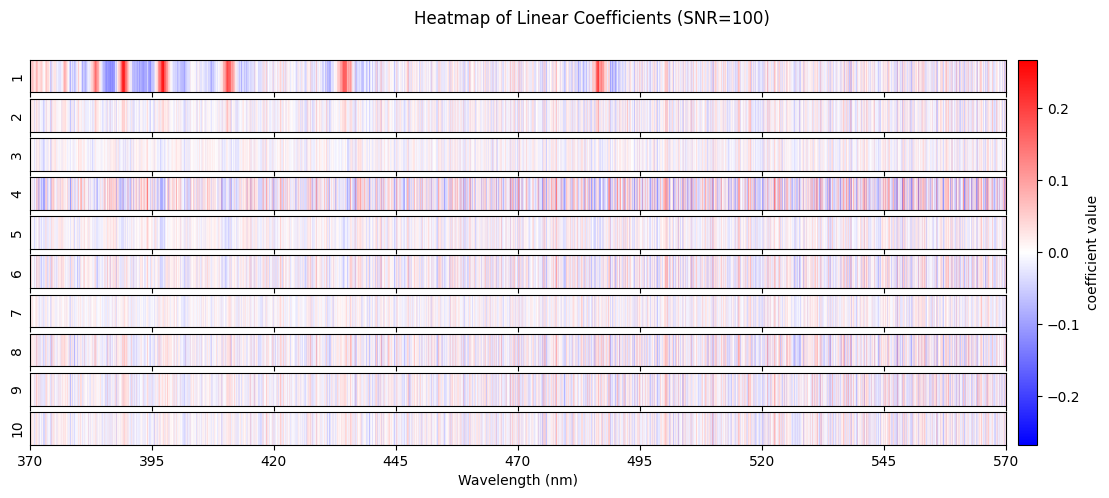

In [18]:
# Split the heatmap into 10 rows (one per label/row)
import numpy as np
import matplotlib.pyplot as plt

arr = linear_terms.T  # shape: (10, n_pixels)
n_labels, n_pix = arr.shape

# Consistent color scale across all subplots
v = np.nanmax(np.abs(arr)) if np.isfinite(arr).any() else 1.0

fig, axes = plt.subplots(n_labels, 1, figsize=(15, 0.5*n_labels), sharex=True)
if n_labels == 1:
    axes = [axes]

for i in range(n_labels):
    im = axes[i].imshow(arr[i:i+1, :], aspect='auto', cmap='bwr', vmin=-v, vmax=v)
    # Label each row; use your provided `labels` where available
    try:
        axes[i].set_ylabel(str(labels[i]))
    except Exception:
        axes[i].set_ylabel(f"Row {i+1}")
        axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[-1].set_xlabel('Wavelength (nm)')
axes[-1].set_xticks(np.linspace(0, n_pix - 1, 9))
axes[-1].set_xticklabels(['370','395','420','445','470','495','520','545','570'])

# Single colorbar for all subplots on the right
cbar = fig.colorbar(im, ax=axes, orientation='vertical', location='right', pad=0.01)
cbar.set_label('coefficient value')
fig.suptitle('Heatmap of Linear Coefficients (SNR=100)')